In [407]:
#Importing needed libraries
import requests
import pandas as pd
from datetime import datetime
import geopandas as gpd
import fiona
import time
from json import JSONDecodeError
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from personal_lib import general_functions as gf
import re
from typing import Optional, List, Tuple
import googlemaps
import os
import math
import pyogrio
import geopandas as gpd
import io
from shapely import wkt
from matplotlib.patches import Patch








## Reading in the Prepped Data from parts 1 and 2 

In [361]:

### Reading in differen building data slices from Part 1 
buildings_data_2010_2017_canopy = pd.read_csv("building_final_2010_2017_canopy_20251116.csv")
buildings_data_all_years_canopy = pd.read_csv("building_final_all_yrs_canopy_20251116.csv")
# max_buildings_no_footprint_2010_2017 = pd.read_csv('max_buildings_no_footprint_2010_2017_20251116.csv')
# max_buildings_no_footprint_all_years = pd.read_csv('max_buildings_no_footprint_all_years_20251116.csv')

## Starting with the buildings_data_2010_2017_canopy

#### Limiting to those that have EUI values 

In [362]:
## Limiting to the columnd relevant for the analysis
core_columns = ['year_ending_year', 'property_id', 'bbl', 'address_1', 'address_2', 'city','boroname','ct2010',
                'latitude', 'longitude','geocode_key',
                'year_built','NumFloors','UnitsRes', 'stories','weather_normalized_site_eui',  'canopy_change_class',
               'construction_year', 'ground_elevation','height_roof']
## We need the main var to be present
print(buildings_data_2010_2017_canopy.shape)
working_buildings_bbls = buildings_data_2010_2017_canopy['bbl'][~buildings_data_2010_2017_canopy["weather_normalized_site_eui"].isnull()].unique()
working_buildings = buildings_data_2010_2017_canopy[buildings_data_2010_2017_canopy['bbl'].isin(working_buildings_bbls)]
print(working_buildings.shape)
## Need to confirm we have bbls that exist in every year. 
# working_buildings_lim = working_buildings[core_columns]

(6888, 82)
(6880, 82)


In [363]:
print(working_buildings.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"nunique"}))

                                       bbl
canopy_change_class year_ending_year      
Gain                2010               202
                    2017               202
Loss                2010               107
                    2017               107
No Change           2010              1093
                    2017              1093


In [60]:
### There are instances of multiple variations of the addresses in here for each BBL 
mult_address = working_buildings.groupby(['bbl']).agg({"address_1":"nunique"}).reset_index()
multiple_addresses = mult_address[mult_address['address_1']>1]
for_cleaning = working_buildings[["bbl","address_1","address_2","city"]][working_buildings["bbl"].isin(multiple_addresses['bbl'].unique())].drop_duplicates().sort_values(by='bbl')
## kicking out to CSV for manual cleaning of each address in excel 
# for_cleaning.to_csv("for_cleaning.csv",index=False)
## Reading Cleaned FIle back in 
cleaned = pd.read_csv('for_cleaning.csv', encoding='cp1252')

In [68]:
### Fixing the Working buildings Df 
single_enrty = working_buildings[~working_buildings['bbl'].isin(multiple_addresses['bbl'].unique())]
multi_entry = working_buildings[working_buildings['bbl'].isin(multiple_addresses['bbl'].unique())]


In [71]:
multi_entry_fixed = multi_entry.merge(for_cleaning, on=['bbl'])
multi_entry_fixed['address_1'] = multi_entry_fixed['address_1_y'].combine_first(multi_entry_fixed['address_1_x'])
multi_entry_fixed['address_2'] = multi_entry_fixed['address_2_y'].combine_first(multi_entry_fixed['address_2_x'])
multi_entry_fixed['city']= multi_entry_fixed['city_y'].combine_first(multi_entry_fixed['city_x'])
multi_entry_fixed = multi_entry_fixed.drop(columns=["address_1_x","address_1_x","city_x","address_1_y","address_1_y","city_y"])
#Finalized working buildings 
working_buildings_cleaned_addresses = pd.concat([single_enrty,multi_entry_fixed])

In [81]:
# working_buildings_cleaned_addresses
print(working_buildings_cleaned_addresses.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(working_buildings_cleaned_addresses.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"count"}))
## There are other issues here for multiple rows, hodling off on further cleaning because we will be doing more data triming before modeling


                                       bbl
canopy_change_class year_ending_year      
Gain                2010               202
                    2017               202
Loss                2010               107
                    2017               107
No Change           2010              1093
                    2017              1093
                                       bbl
canopy_change_class year_ending_year      
Gain                2010               780
                    2017               577
Loss                2010               397
                    2017               292
No Change           2010              4202
                    2017              3043


### Using the Footprint Geom for spatial join with trees. 

In [82]:
## Same Year limit on trees
trees_data = pd.read_csv("trees_processed_for_part3.csv")
print(trees_data.shape)
working_trees = trees_data[((trees_data["manual_year"].isin([2010,2017]))
                            &((trees_data['include_in_year']==True) | (trees_data['include_in_year'].isnull())))]
print(working_trees.shape)

C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\159319654.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_data = pd.read_csv("trees_processed_for_part3.csv")


(5569204, 22)
(1391222, 22)


In [84]:
# starting from your building DF
bdf = working_buildings_cleaned_addresses.copy()
bdf["geometry"] = bdf["geometry"].apply(wkt.loads)

# 2) Wrap as GeoDataFrame, NYC coords in feet (EPSG:2263)
buildings_gdf = gpd.GeoDataFrame(bdf, geometry="geometry", crs="EPSG:2263")

# 3) Add a 50 ft buffer around each building footprint
buildings_buffered = buildings_gdf.copy()
buildings_buffered["geometry"] = buildings_buffered.geometry.buffer(50)

In [85]:
# points_df: regular pandas DataFrame with latitude / longitude columns
trees_gdf = gpd.GeoDataFrame(
    working_trees,
    geometry=gpd.points_from_xy(working_trees["lon"], working_trees["lat"]),
    crs="EPSG:4326"        # WGS84 (typical for lat/long)
)
# project points into the same CRS as buildings (feet)
trees_gdf_2263 = trees_gdf.to_crs(buildings_buffered.crs)

points_with_buildings = gpd.sjoin(
    trees_gdf_2263,
    buildings_buffered[["bbl", "geometry"]],  # plus any building cols you want
    how="left",          # keep all points, add building info where it matches
    predicate="within"   # point is within buffered building polygon
)


In [125]:
trees_near_buildings = points_with_buildings[points_with_buildings["bbl"].notna()].copy()
print("Trees near buildings:", len(trees_near_buildings))
trees_near_buildings.head()

Trees near buildings: 274118


,objectid,dbh,tpstructure,tpcondition,plantingspaceglobalid,geometry,globalid,genusspecies,createddate,location,stumpdiameter,updateddate,riskrating,riskratingdate,planteddate,lat,lon,removal_date_est,removed_before_2018,removal_year,include_in_year,manual_year,index_right,bbl
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT (994673.637 228776.393),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",0.0,NaN,NaN,NaN,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010,1248.0,1.018360e+09
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT (994673.637 228776.393),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",0.0,NaN,NaN,NaN,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010,1249.0,1.018360e+09
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT (994673.637 228776.393),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",0.0,NaN,NaN,NaN,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010,1250.0,1.018360e+09
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT (994673.637 228776.393),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",0.0,NaN,NaN,NaN,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010,6044.0,1.018360e+09
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT (994673.637 228776.393),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",0.0,NaN,NaN,NaN,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010,6045.0,1.018360e+09


In [126]:
trees_near_buildings = trees_near_buildings[((trees_near_buildings['include_in_year'].isnull())
                                             |(trees_near_buildings['include_in_year']==True))].copy()
building_trees_grouped = trees_near_buildings.groupby(['manual_year','bbl','genusspecies']).agg({'objectid':'nunique'}).reset_index()
building_trees_grouped = building_trees_grouped.rename(columns={"objectid":"tree_count"})

In [127]:
building_trees_grouped.shape

(16054, 4)

In [128]:
building_trees_all = working_buildings.merge(building_trees_grouped,
                                          how='inner',
                                          right_on=['manual_year','bbl'],left_on = ['year_ending_year','bbl'])

In [129]:
building_trees_all.shape

(38705, 85)

In [130]:
##Checking this along the way
print(building_trees_all.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"count"}))

                                       bbl
canopy_change_class year_ending_year      
Gain                2010               199
                    2017               199
Loss                2010               104
                    2017               104
No Change           2010              1083
                    2017              1083
                                        bbl
canopy_change_class year_ending_year       
Gain                2010               3170
                    2017               2370
Loss                2010               1499
                    2017               1086
No Change           2010              17277
                    2017              13281


### limiting the columns to those that a needed for modeling / analysis. Droping unusable 

In [208]:
building_trees_all_lim =building_trees_all[["year_ending_year","ct2010","bbl",'year_built','BldgClass','NumFloors', 'UnitsRes', 'stories',"construction_year",
                   "ground_elevation","height_roof","weather_normalized_site_eui","canopy_change_class","genusspecies","tree_count"]].drop_duplicates()
building_trees_all_lim = building_trees_all_lim.rename(columns={"year_ending_year":"year"})
building_trees_all_lim["year_built"] = building_trees_all_lim["year_built"].combine_first(building_trees_all_lim["construction_year"])
## Singluwer Null building for Num floors
building_trees_all = building_trees_all[~building_trees_all['NumFloors'].isnull()]
building_trees_all_lim = building_trees_all_lim.drop(columns=["construction_year"])

In [209]:
##Checking this along the way
print(building_trees_all_lim.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                           bbl
canopy_change_class year      
Gain                2010   197
                    2017   197
Loss                2010   104
                    2017   104
No Change           2010  1081
                    2017  1081
                           bbl
canopy_change_class year      
Gain                2010  1150
                    2017  1182
Loss                2010   587
                    2017   598
No Change           2010  6453
                    2017  6570


### Enriching for those that have null year built vals

In [210]:
## Manual Filling in these values 
need_year_bbl = list(building_trees_all_lim['bbl'][building_trees_all_lim["year_built"].isnull()].unique())

# build the SoQL WHERE clause:  bbl IN ('...', '...', ...)
where_clause = "bbl IN ({})".format(
    ",".join(f"'{b}'" for b in need_year_bbl)
)

url = "https://data.cityofnewyork.us/resource/64uk-42ks.json"

params = {
    "$select": "*",         # or pick specific columns
    "$where": where_clause
    # you can also add "$limit": 50000 if you want
}

resp = requests.get(url, params=params)
resp.raise_for_status()

rows = resp.json()
df = pd.DataFrame(rows)

print(df.head())
print(df.shape)


  borough block  lot   cd  ct2010 cb2010 schooldist council zipcode firecomp  \
0      MN   773  134  104      91   3000          2       3   10011     E001   
1      MN  1624   45  111  158.02   1000          2       8   10029     E053   
2      BX  2407   23  203     141   3003          7      17   10451     L055   
3      BX  2526   90  204     199   4002          9      16   10452     E068   
4      BX  2880  135  205  205.01   3000          9      14   10453     L059   

  policeprct healtharea sanitboro sanitsub                 address zonedist1  \
0         10       5200         1       2A      202 WEST 24 STREET       R8A   
1         23       2820         1       1A   1501 LEXINGTON AVENUE      R7-2   
2         42       3400         2       1B      863 MELROSE AVENUE        R8   
3         44       3310         2       2A       1131 OGDEN AVENUE      R7-1   
4         46       2210         2       1B  1571 UNDERCLIFF AVENUE      R7-1   

  zonedist2  splitzone bldgclass landu

#### #Normalize BBL keys on BOTH dataframes as strings


In [211]:

# building_trees_all_lim: bbl is already int or numeric
building_trees_all_lim["bbl_key"] = (
    pd.to_numeric(building_trees_all_lim["bbl"], errors="coerce")
      .astype("Int64")
      .astype(str)
)

# df from the API: values like '1007730134.00000000'
df["bbl_key"] = (
    pd.to_numeric(df["bbl"], errors="coerce")   # turn '1007730134.00000000' into 1007730134
      .astype("Int64")
      .astype(str)
)

# 2. Build mapping bbl_key -> yearbuilt
bbl_to_yearbuilt = (
    df.groupby("bbl_key")["yearbuilt"]
      .first()          # or max/min if you prefer
)

# 3. Map into the building dataframe and fill only null year_built
mapped_years = building_trees_all_lim["bbl_key"].map(bbl_to_yearbuilt)

building_trees_all_lim["year_built"] = (
    building_trees_all_lim["year_built"]
      .fillna(mapped_years)
)

# (optional) ensure year_built is numeric
building_trees_all_lim["year_built"] = pd.to_numeric(
    building_trees_all_lim["year_built"], errors="coerce"
)


In [212]:
building_trees_all_lim['year_built'] = building_trees_all_lim['year_built'].astype(int)
building_trees_all_lim = building_trees_all_lim.drop(columns=['bbl_key'])

In [213]:
##Checking this along the way
print(building_trees_all_lim.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                           bbl
canopy_change_class year      
Gain                2010   197
                    2017   197
Loss                2010   104
                    2017   104
No Change           2010  1081
                    2017  1081
                           bbl
canopy_change_class year      
Gain                2010  1150
                    2017  1182
Loss                2010   587
                    2017   598
No Change           2010  6453
                    2017  6570


In [ ]:
##

#### Last Minute Filters for Data Cleaning




In [225]:
## No null EUI Values
null_eui_bbls = building_trees_all_lim['bbl'][building_trees_all_lim['weather_normalized_site_eui'].isnull()].unique()
building_trees_all_lim= building_trees_all_lim[~building_trees_all_lim['bbl'].isin(null_eui_bbls)]
## One off fix (from bellw)
building_trees_all_lim['year_built'][building_trees_all_lim['bbl'].isin([1007970007])]=2005


C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\4029850022.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  building_trees_all_lim['year_built'][building_trees_all_lim['bbl'].isin([1007970007])]=2005
C:\Users\johnf\AppData\Local\Temp\ip

In [226]:
building_trees_all_lim['year_built'].iloc[0]

1927

In [227]:
### Aggregate up one more level because i think the genius / species information is superfluous for now 
building_trees_all_lim_trees = building_trees_all_lim.groupby(['year', 'ct2010', 'bbl', 'year_built', 'BldgClass',
                                                               'NumFloors','canopy_change_class']).agg({
        "UnitsRes":'mean',"ground_elevation":'mean',"height_roof":'mean',"weather_normalized_site_eui":'mean','tree_count':'sum'}).reset_index()
## Count of unique genus species? or no, too messy?
building_trees_all_lim_trees
# building_trees_all_lim.to_csv("building_trees_all_lim_20251120_final.csv",index=False)                                        

,year,ct2010,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui,tree_count
0,2010,202,1002430056,1962,D4,21.0,No Change,211.0,12.0,190.050000,78.8,2
1,2010,202,1002440019,1964,D4,21.0,No Change,124.0,12.0,189.650000,78.8,8
2,2010,202,1002590001,1964,D4,21.0,No Change,124.0,20.0,184.240000,78.8,12
3,2010,202,1002590071,1964,D4,21.0,No Change,145.0,30.0,182.520000,78.8,3
4,2010,202,1002670001,1964,D4,21.0,No Change,141.0,32.0,182.680000,78.8,8
...,...,...,...,...,...,...,...,...,...,...,...,...
2533,2017,45102,2033980087,1958,D4,7.0,No Change,78.0,105.0,66.088033,122.4,7
2534,2017,45102,2033980097,1957,D4,7.0,Loss,80.0,102.0,67.419190,122.1,12
2535,2017,46201,2051410265,1994,N2,12.0,No Change,0.0,22.0,110.640000,78.1,8
2536,2017,46201,2051411120,1992,I9,7.0,No Change,100.0,16.0,64.440000,82.2,4


In [228]:
##Checking this along the way
print(building_trees_all_lim_trees.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010  184
                    2017  184
Loss                2010   95
                    2017   95
No Change           2010  988
                    2017  988
                          bbl
canopy_change_class year     
Gain                2010  184
                    2017  184
Loss                2010   96
                    2017   95
No Change           2010  989
                    2017  990


In [229]:
#### Removing those buidlings with Extreme 99% outliers that throw the distribition off from being normal. 
print(building_trees_all_lim_trees.shape)
q99 = building_trees_all_lim_trees["weather_normalized_site_eui"].quantile(0.99)
bbls_eui_under99= building_trees_all_lim_trees['bbl'][building_trees_all_lim_trees["weather_normalized_site_eui"] > q99].unique()
building_trees_all_lim_trees_eui_extremes = building_trees_all_lim_trees[~building_trees_all_lim_trees['bbl'].isin(bbls_eui_under99)]
print(building_trees_all_lim_trees_eui_extremes.shape) ## dropped about 25 rows

(2538, 12)
(2487, 12)


In [230]:
##Checking this along the way
print(building_trees_all_lim_trees_eui_extremes.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees_eui_extremes.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010  176
                    2017  176
Loss                2010   94
                    2017   94
No Change           2010  972
                    2017  972
                          bbl
canopy_change_class year     
Gain                2010  176
                    2017  176
Loss                2010   94
                    2017   94
No Change           2010  973
                    2017  974


In [231]:
### Staying to BldgClass D, and C. Droppign the other ones. 
#(https://www.nyc.gov/assets/finance/jump/hlpbldgcode.html)
bbl_bldgclass = building_trees_all_lim_trees_eui_extremes['bbl'][building_trees_all_lim_trees_eui_extremes['BldgClass'].astype(str).str[0].isin(["D","C"])].unique()
building_trees_all_lim_trees2 = building_trees_all_lim_trees_eui_extremes[building_trees_all_lim_trees_eui_extremes['bbl'].isin(bbl_bldgclass)].copy()
print(building_trees_all_lim_trees2.shape) # Dropped under `100 rows


(2461, 12)


In [325]:
building_trees_all_lim_trees4.groupby(["BldgClass"]).agg({'bbl':'nunique'})

,bbl
BldgClass,
C1,62
C4,3
C6,2
C7,26
D0,3
D1,240
D3,11
D4,95
D5,5


In [327]:
#Commercial Flag
building_trees_all_lim_trees4['commercial_floor_flag']=None
building_trees_all_lim_trees4['commercial_floor_flag'][building_trees_all_lim_trees4['BldgClass'].isin(['C7','D6','D7'])]=1
building_trees_all_lim_trees4['commercial_floor_flag'][building_trees_all_lim_trees4['BldgClass'].isin(['C0','C1','C2','C3','C4','C5','C6',
                                                                                                        'D0','D1','D2','D3','D4','D5','D8','D9'])]=0

C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\773749812.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  building_trees_all_lim_trees4['commercial_floor_flag'][building_trees_all_lim_trees4['BldgClass'].isin(['C7','D6','D7'])]=1
C:\Us

In [232]:
##Checking this along the way
print(building_trees_all_lim_trees2.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees2.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010  173
                    2017  173
Loss                2010   94
                    2017   94
No Change           2010  962
                    2017  962
                          bbl
canopy_change_class year     
Gain                2010  173
                    2017  173
Loss                2010   94
                    2017   94
No Change           2010  963
                    2017  964


In [235]:
### Canopy loss in 2017 there is a numeric mismatch
# test = building_trees_all_lim_trees2[((building_trees_all_lim_trees2['year']==2017)&(building_trees_all_lim_trees2['canopy_change_class']=='Loss'))]
# grouped = test.groupby('bbl').agg({'year':'count'}).reset_index()
# dupes = grouped[grouped['year']>1]
### Two values for year built for this bbl, along with 2 values for weather_normalized_site_eui. needs manual fixing (adding above)
# building_trees_all_lim_trees2[building_trees_all_lim_trees2['bbl'].isin(dupes['bbl'].unique())].sort_values(by='bbl')

In [236]:
### Kepping to buildings that are 6 Stories and under
bbls_under6 = building_trees_all_lim_trees2['bbl'][(building_trees_all_lim_trees2['NumFloors']<=6)].unique()
building_trees_all_lim_trees3 = building_trees_all_lim_trees2[building_trees_all_lim_trees2['bbl'].isin(bbls_under6)].copy()
print(building_trees_all_lim_trees3.shape)## ~1500 rows dropped 

(1066, 12)


In [237]:
##Checking this along the way
print(building_trees_all_lim_trees3.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees3.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010   98
                    2017   98
Loss                2010   38
                    2017   38
No Change           2010  397
                    2017  397
                          bbl
canopy_change_class year     
Gain                2010   98
                    2017   98
Loss                2010   38
                    2017   38
No Change           2010  397
                    2017  397


In [244]:
## Built 1900 or after 
after_1900_bbl = building_trees_all_lim_trees3['bbl'][(building_trees_all_lim_trees3['year_built']>=1900)].unique()
building_trees_all_lim_trees4 = building_trees_all_lim_trees3[building_trees_all_lim_trees3['bbl'].isin(after_1900_bbl)].copy()
print(building_trees_all_lim_trees4.shape) #~4 rows dropped 

(1066, 12)


In [253]:
### Replicating the building brackets from (https://www.fs.usda.gov/psw/publications/documents/psw_gtr171/psw_gtr171.pdf) 
#Pre-1950, 1951-1980, Post-1980


# 2) Create year_built bracket feature
bins   = [-np.inf, 1949, 1980, np.inf]
labels = ["Pre-1950", "1950-1980", "Post-1980"]

building_trees_all_lim_trees4["year_built_bracket"] = pd.cut(
    building_trees_all_lim_trees4["year_built"],
    bins=bins,
    labels=labels,
    right=True   # intervals are (-inf,1949], (1949,1980], (1980,inf]
)

# Optional: check
print(
    building_trees_all_lim_trees4[["year_built", "year_built_bracket"]]
    .head()
)

    year_built year_built_bracket
15        1920           Pre-1950
16        1983          Post-1980
17        1972          1950-1980
22        1900           Pre-1950
23        1925           Pre-1950


In [245]:
##Checking this along the way
print(building_trees_all_lim_trees4.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees4.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010   98
                    2017   98
Loss                2010   38
                    2017   38
No Change           2010  397
                    2017  397
                          bbl
canopy_change_class year     
Gain                2010   98
                    2017   98
Loss                2010   38
                    2017   38
No Change           2010  397
                    2017  397


In [ ]:
building_trees_all_lim_trees4

#### Checking out the issue. Issue found. going back and adding avgs for those that have multiple value per uilding per year. 
#### Weird with some buildings being on same bbl / multiple addresses etc 

In [144]:
# ### The4se filters dropped a different number of buildings in different years. Need to see why. 
# bbl_2010 = building_trees_all_lim_trees4[building_trees_all_lim_trees4['year']==2010]
# print(bbl_2010.shape)
# bbl_2010 = bbl_2010.drop_duplicates()
# print(bbl_2010.shape)
# bbl_2017 = building_trees_all_lim_trees4[building_trees_all_lim_trees4['year']==2017]
# print(bbl_2017.shape)
# bbl_2017 = bbl_2017.drop_duplicates()
# print(bbl_2017.shape)

# ##Checking this along the way
# print(bbl_2010.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
# bbl_2010_flat = bbl_2010.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}).reset_index()
# bbl_2010_flat = bbl_2010_flat.rename(columns = {'bbl':'2010_bbl_count'}).drop(columns='year')

# print(bbl_2017.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
# bbl_2017_flat = bbl_2017.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}).reset_index()
# bbl_2017_flat = bbl_2017_flat.rename(columns = {'bbl':'2017_bbl_count'}).drop(columns='year')

# # unique_bbl = bbl_2010_flat.merge(bbl_2017_flat, on=['canopy_change_class'])
# # unique_bbl

# ## 2010 Cheks
# # bbl_mulitple = bbl_2010.groupby(["bbl"]).agg({"year":"count"}).reset_index()
# # bbl_mulitple = bbl_mulitple[bbl_mulitple['year']>1]
# # bbl_2010[bbl_2010['bbl'].isin(bbl_mulitple['bbl'].unique())].sort_values(by=['bbl'])

# #### 2017 Chekcs 
# # bbl_mulitple = bbl_2017.groupby(["bbl"]).agg({"year":"count"}).reset_index()
# # bbl_mulitple = bbl_mulitple[bbl_mulitple['year']>1]
# # bbl_2017[bbl_2017['bbl'].isin(bbl_mulitple['bbl'].unique())].sort_values(by=['bbl'])

(568, 12)
(568, 12)
(611, 12)
(611, 12)


### End of checks 

 ### Exploratory Data Analysis Start now that Data is Finalized

In [365]:
##Checking this along the way
print(building_trees_all_lim_trees4.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees4.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010   98
                    2017   98
Loss                2010   38
                    2017   38
No Change           2010  397
                    2017  397
                          bbl
canopy_change_class year     
Gain                2010   98
                    2017   98
Loss                2010   38
                    2017   38
No Change           2010  397
                    2017  397


In [364]:
building_trees_all_lim_trees4

,year,ct2010,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui,tree_count,year_built_bracket,commercial_floor_flag
15,2010,001900,2023090001,1920,D7,5.0,Gain,75.0,9.0,92.680000,40.7,12,Pre-1950,1
16,2010,002201,1003450048,1983,D3,6.0,No Change,172.0,21.0,55.770000,67.7,31,Post-1980,0
17,2010,002500,2022810021,1972,D1,6.0,No Change,107.0,44.0,62.050000,78.7,10,1950-1980,0
22,2010,003001,1004110045,1900,D1,6.0,Gain,52.0,33.0,55.430000,25.0,2,Pre-1950,0
23,2010,003100,2025820034,1925,C7,6.0,Loss,77.0,34.0,63.292863,110.0,17,Pre-1950,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,2017,043100,2033560126,1928,D1,6.0,Loss,66.0,150.0,70.520000,74.7,3,Pre-1950,0
2529,2017,043100,2033560180,1929,D1,6.0,Gain,61.0,105.0,96.980000,88.5,16,Pre-1950,0
2530,2017,043400,2050440030,1931,D1,6.0,No Change,61.0,175.0,66.310000,77.5,17,Pre-1950,0
2532,2017,045102,2033880001,1927,C7,5.0,No Change,57.0,149.0,59.260000,79.2,14,Pre-1950,1


### Setting colors for visuals


In [411]:
colors = {
    "mint_cream": "#F1F7ED",
    "dark_slate_grey": "#243E36",
    "muted_teal": "#7CA982",
    "frosted_mint": "#E0EEC6",
    "old_gold": "#C2A83E",
}

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

canopy_palette = {
    "Gain": colors["muted_teal"],
    "Loss": colors["old_gold"],
    "No Change": colors["mint_cream"]
}

# Choropleth colormap (buildings per tract)
bldg_cmap = LinearSegmentedColormap.from_list(
    "bldg_cmap",
    [colors["mint_cream"], colors["muted_teal"],]
)


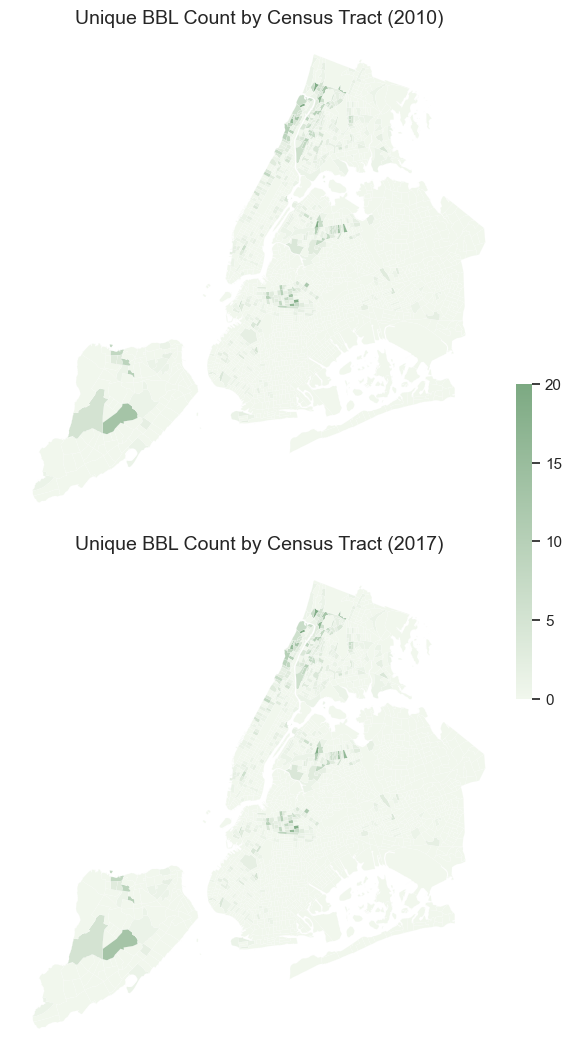

In [421]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Aim roughly at US letter size, portrait
fig, axes = plt.subplots(
    2, 1,
    figsize=(8.5, 10.5),          # page-like proportions
    constrained_layout=True
)

for gdf, ax, title in [
    (ct2010_bldg_2010, axes[0], "Unique BBL Count by Census Tract (2010)"),
    (ct2010_bldg_2017, axes[1], "Unique BBL Count by Census Tract (2017)"),
]:
    gdf.plot(
        column="bbl_count",
        ax=ax,
        cmap=bldg_cmap,
        linewidth=0.1,
        edgecolor="white",
        legend=False,
        vmin=0,
        vmax=20,
    )
    ax.set_title(title, fontsize=14, pad=6)
    ax.set_axis_off()

# --- minimalist colorbar, kept slim ---
norm = Normalize(vmin=0, vmax=20)
sm = plt.cm.ScalarMappable(norm=norm, cmap=bldg_cmap)
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=axes,
    location="right",
    fraction=0.02,        # smaller fraction = slimmer bar
    pad=0.01,
    ticks=np.arange(0, 21, 5),
    format="%d",
)

cbar.outline.set_visible(False)
plt.savefig("fig_2_bbl_maps.png", dpi=300, bbox_inches="tight")

plt.show()


In [395]:
# Path to your geodatabase (.gdb)
# https://github.com/CityOfNewYork/nyc-geo-metadata/blob/main/Metadata/Metadata_TreeCanopyChange.md
gdb_path = r"C:\Users\johnf\Downloads\Tree_Canopy_Change (1)\Tree_Canopy_Change\NYC_TreeCanopyChange_2010_2017.gdb"

# List all layers in the geodatabase
layers = fiona.listlayers(gdb_path)
print("Layers available:", layers)

# Read a specific layer into a GeoDataFrame
gdf = gpd.read_file(gdb_path, layer=layers[0])  # Replace [0] with your desired layer
print(gdf.head())

# Optional: save as shapefile or GeoJSON
# gdf.to_file("output.shp") 
# gdf.to_file("output.geojson", driver="GeoJSON")

canopy_change = gdf.copy()
# canopy_change
print(canopy_change.crs)

Layers available: ['NYC_TreeCanopyChange_2010_2017']


C:\Python310\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


       Class  Shape_Length    Shape_Area  \
0  No Change    732.955182   5800.500001   
1  No Change   2079.456465  35005.875002   
2  No Change    228.557599   1984.500000   
3  No Change    125.726893    617.750000   
4  No Change     41.031601     90.750000   

                                            geometry  
0  MULTIPOLYGON (((1008879.93 272372.3, 1008878.4...  
1  MULTIPOLYGON (((1008749.43 271870.8, 1008748.9...  
2  MULTIPOLYGON (((1008704.43 272105.3, 1008701.9...  
3  MULTIPOLYGON (((1009015.43 272757.3, 1009013.4...  
4  MULTIPOLYGON (((1008794.93 270669.8, 1008781.4...  
EPSG:2263


In [ ]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

# Same palette you already have
canopy_palette = {
    "Gain":      "#7CA982",  # muted teal
    "Loss":      "#C2A83E",  # old gold
    "No Change": "#243E36",  # dark slate grey
}

classes = ["Gain", "Loss", "No Change"]

# 3 rows, 1 column (stacked vertically)
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(8, 12),   # tuned for an 8.5x11 Word page
    sharex=True,
    sharey=True
)

# Make sure axes is always iterable
axes = axes.ravel()

for ax, cls in zip(axes, classes):
    # Background
    ax.set_facecolor("#F1F7ED")

    # 1. Base layer – tracts in light grey
    ct2010.boundary.plot(
        ax=ax,
        linewidth=0.3,
        edgecolor="#B0B0B0",
        zorder=1
    )

    # 2. Canopy polygons for this class only
    subset = canopy_change[canopy_change["Class"] == cls]
    subset.plot(
        ax=ax,
        color=canopy_palette[cls],
        edgecolor="none",
        alpha=0.85,
        linewidth=0,
        zorder=2
    )

    # 3. Per-panel title
    ax.set_title(f"{cls} in LiDAR-Derived Canopy Change (2010–2017)",
                 fontsize=11, pad=6)
    ax.set_axis_off()

# Overall figure title
fig.suptitle("LiDAR-Derived Canopy Change by Class (2010–2017)",
             fontsize=14, y=0.98)
# Shared legend for all three panels
handles = [
    Patch(facecolor=color, edgecolor="none", label=cls)
    for cls, color in canopy_palette.items()
]
fig.legend(
    handles=handles,
    title="Canopy Change Class",
    loc="lower center",
    bbox_to_anchor=(0.5, 0.02),
    ncol=3,
    frameon=False
)

plt.tight_layout(rect=(0, 0.05, 1, 0.95))
plt.savefig("fig_3_can_map_by_class.png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 800x500 with 0 Axes>

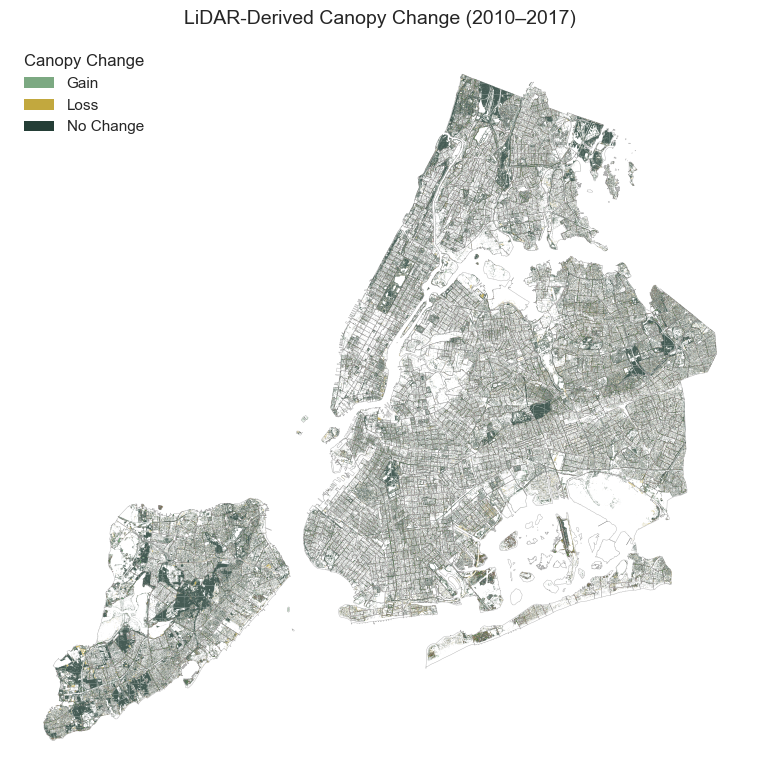

In [426]:

fig, ax = plt.subplots(figsize=(12, 8))

# Optional: slightly off-white background so grey lines are visible
ax.set_facecolor("#F1F7ED")

# 1. Base layer – tracts / city boundary in light grey
ct2010.boundary.plot(
    ax=ax,
    linewidth=0.3,
    edgecolor="#B0B0B0",  # darker than before so it’s visible
    zorder=1
)

# 2. Canopy change polygons – higher contrast colors
canopy_palette = {
    "Gain":      "#7CA982",  # muted teal
    "Loss":      "#C2A83E",  # old gold
    "No Change": "#243E36",  # dark slate grey
}

for cls, color in canopy_palette.items():
    canopy_change[canopy_change["Class"] == cls].plot(
        ax=ax,
        color=color,
        edgecolor="none",
        alpha=0.85,      # much more opaque
        linewidth=0,
        zorder=2
    )

# 3. Title / axes
ax.set_title("LiDAR-Derived Canopy Change (2010–2017)", fontsize=14, pad=12)
ax.set_axis_off()

# 4. Legend using proxy patches (no warnings, clean look)
handles = [
    Patch(facecolor=color, edgecolor="none", label=cls)
    for cls, color in canopy_palette.items()
]
ax.legend(
    handles=handles,
    title="Canopy Change",
    loc="upper left",
    frameon=False
)

plt.tight_layout()
plt.savefig("fig_3_can_map.png", dpi=300, bbox_inches="tight")
plt.show()


### ------ EDA road map END

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, cls in zip(axes, ["Gain", "Loss", "No Change"]):
    ct2010.boundary.plot(ax=ax, linewidth=0.3, edgecolor="#DDDDDD")
    lidar_canopy[lidar_canopy["canopy_change_class"] == cls].plot(
        ax=ax,
        color=canopy_palette[cls],
        markersize=1,
        alpha=0.7
    )
    ax.set_title(f"Canopy {cls}", fontsize=12)
    ax.set_axis_off()

plt.tight_layout()
plt.show()


In [475]:
# # Global style with your colors
# sns.set_theme(
#     style="ticks",
#     rc={
#         "axes.facecolor": "#FAFAFA",
#         "figure.facecolor": "#FAFAFA",
#         "axes.edgecolor": colors["dark_slate_grey"],
#         "xtick.color": colors["dark_slate_grey"],
#         "ytick.color": colors["dark_slate_grey"],
#         "axes.labelcolor": colors["dark_slate_grey"],
#         "grid.color": "#E0E0E0",
#     },
# )
# sns.set_palette(base_palette)

# # Select numeric columns and drop BBL (identifier)
# numeric_df = (
#     building_trees_all_lim_trees4
#     .select_dtypes(include="number")
#     .drop(columns=["BBL"], errors="ignore")  # errors="ignore" keeps it safe if BBL missing
# )
# numeric_df = numeric_df[[c for c in numeric_df.columns if c not in ['bbl','year']]]

# g = sns.pairplot(
#     numeric_df,
#     corner=True,
#     diag_kind="kde",
#     plot_kws={
#         "alpha": 0.7,
#         "s": 25,
#         "edgecolor": "white",
#         "linewidth": 0.5,
#         "color": colors["muted_teal"],
#     },
#     diag_kws={
#         "fill": True,
#         "color": colors["frosted_mint"],
#     },
# )

# # Figure size
# g.fig.set_size_inches(14, 14)

# # Font sizes
# for ax in g.axes.flat:
#     if ax is not None:
#         ax.tick_params(labelsize=12)
#         ax.set_xlabel(ax.get_xlabel(), fontsize=12)
#         ax.set_ylabel(ax.get_ylabel(), fontsize=12)

# plt.tight_layout()
# plt.savefig("fig_4_pairplot_numeric_features_no_bbl.png", dpi=300, bbox_inches="tight")
# plt.show()


In [ ]:
pair_cols = [
    "weather_normalized_site_eui",
    "tree_count",
    "year_built",
    "NumFloors",
    "height_roof",
    "UnitsRes",
    "ground_elevation"
]

# Use a local rc_context so we don't change global matplotlib settings
with plt.rc_context({
    "axes.labelsize": 9,        # axis labels
    "xtick.labelsize": 7,       # x tick labels
    "ytick.labelsize": 7,       # y tick labels
    "legend.fontsize": 8,       # legend entries
    "legend.title_fontsize": 9  # legend title
}):

    sns.set_theme(style="white")  # clean background

    g = sns.pairplot(
        data=building_trees_all_lim_trees4,
        vars=pair_cols,
        hue="canopy_change_class",
        hue_order=order,
        palette=canopy_palette,
        corner=True,
        diag_kind="kde"
    )

    # Make it fit nicely on an 8.5x11 portrait page
    # (you'll insert it at ~6" width in Word)
    g.fig.set_size_inches(6, 6)

    # Replace legend and move to upper-right of the figure
    if g._legend is not None:
        g._legend.remove()

    g.add_legend(
        title="canopy_change_class",
        bbox_to_anchor=(0.98, 0.98),  # near top-right
        loc="upper right",
        borderaxespad=0.0
    )

    g.fig.tight_layout()
    g.fig.savefig("fig_4_pairplot_2.png", dpi=300, bbox_inches="tight")


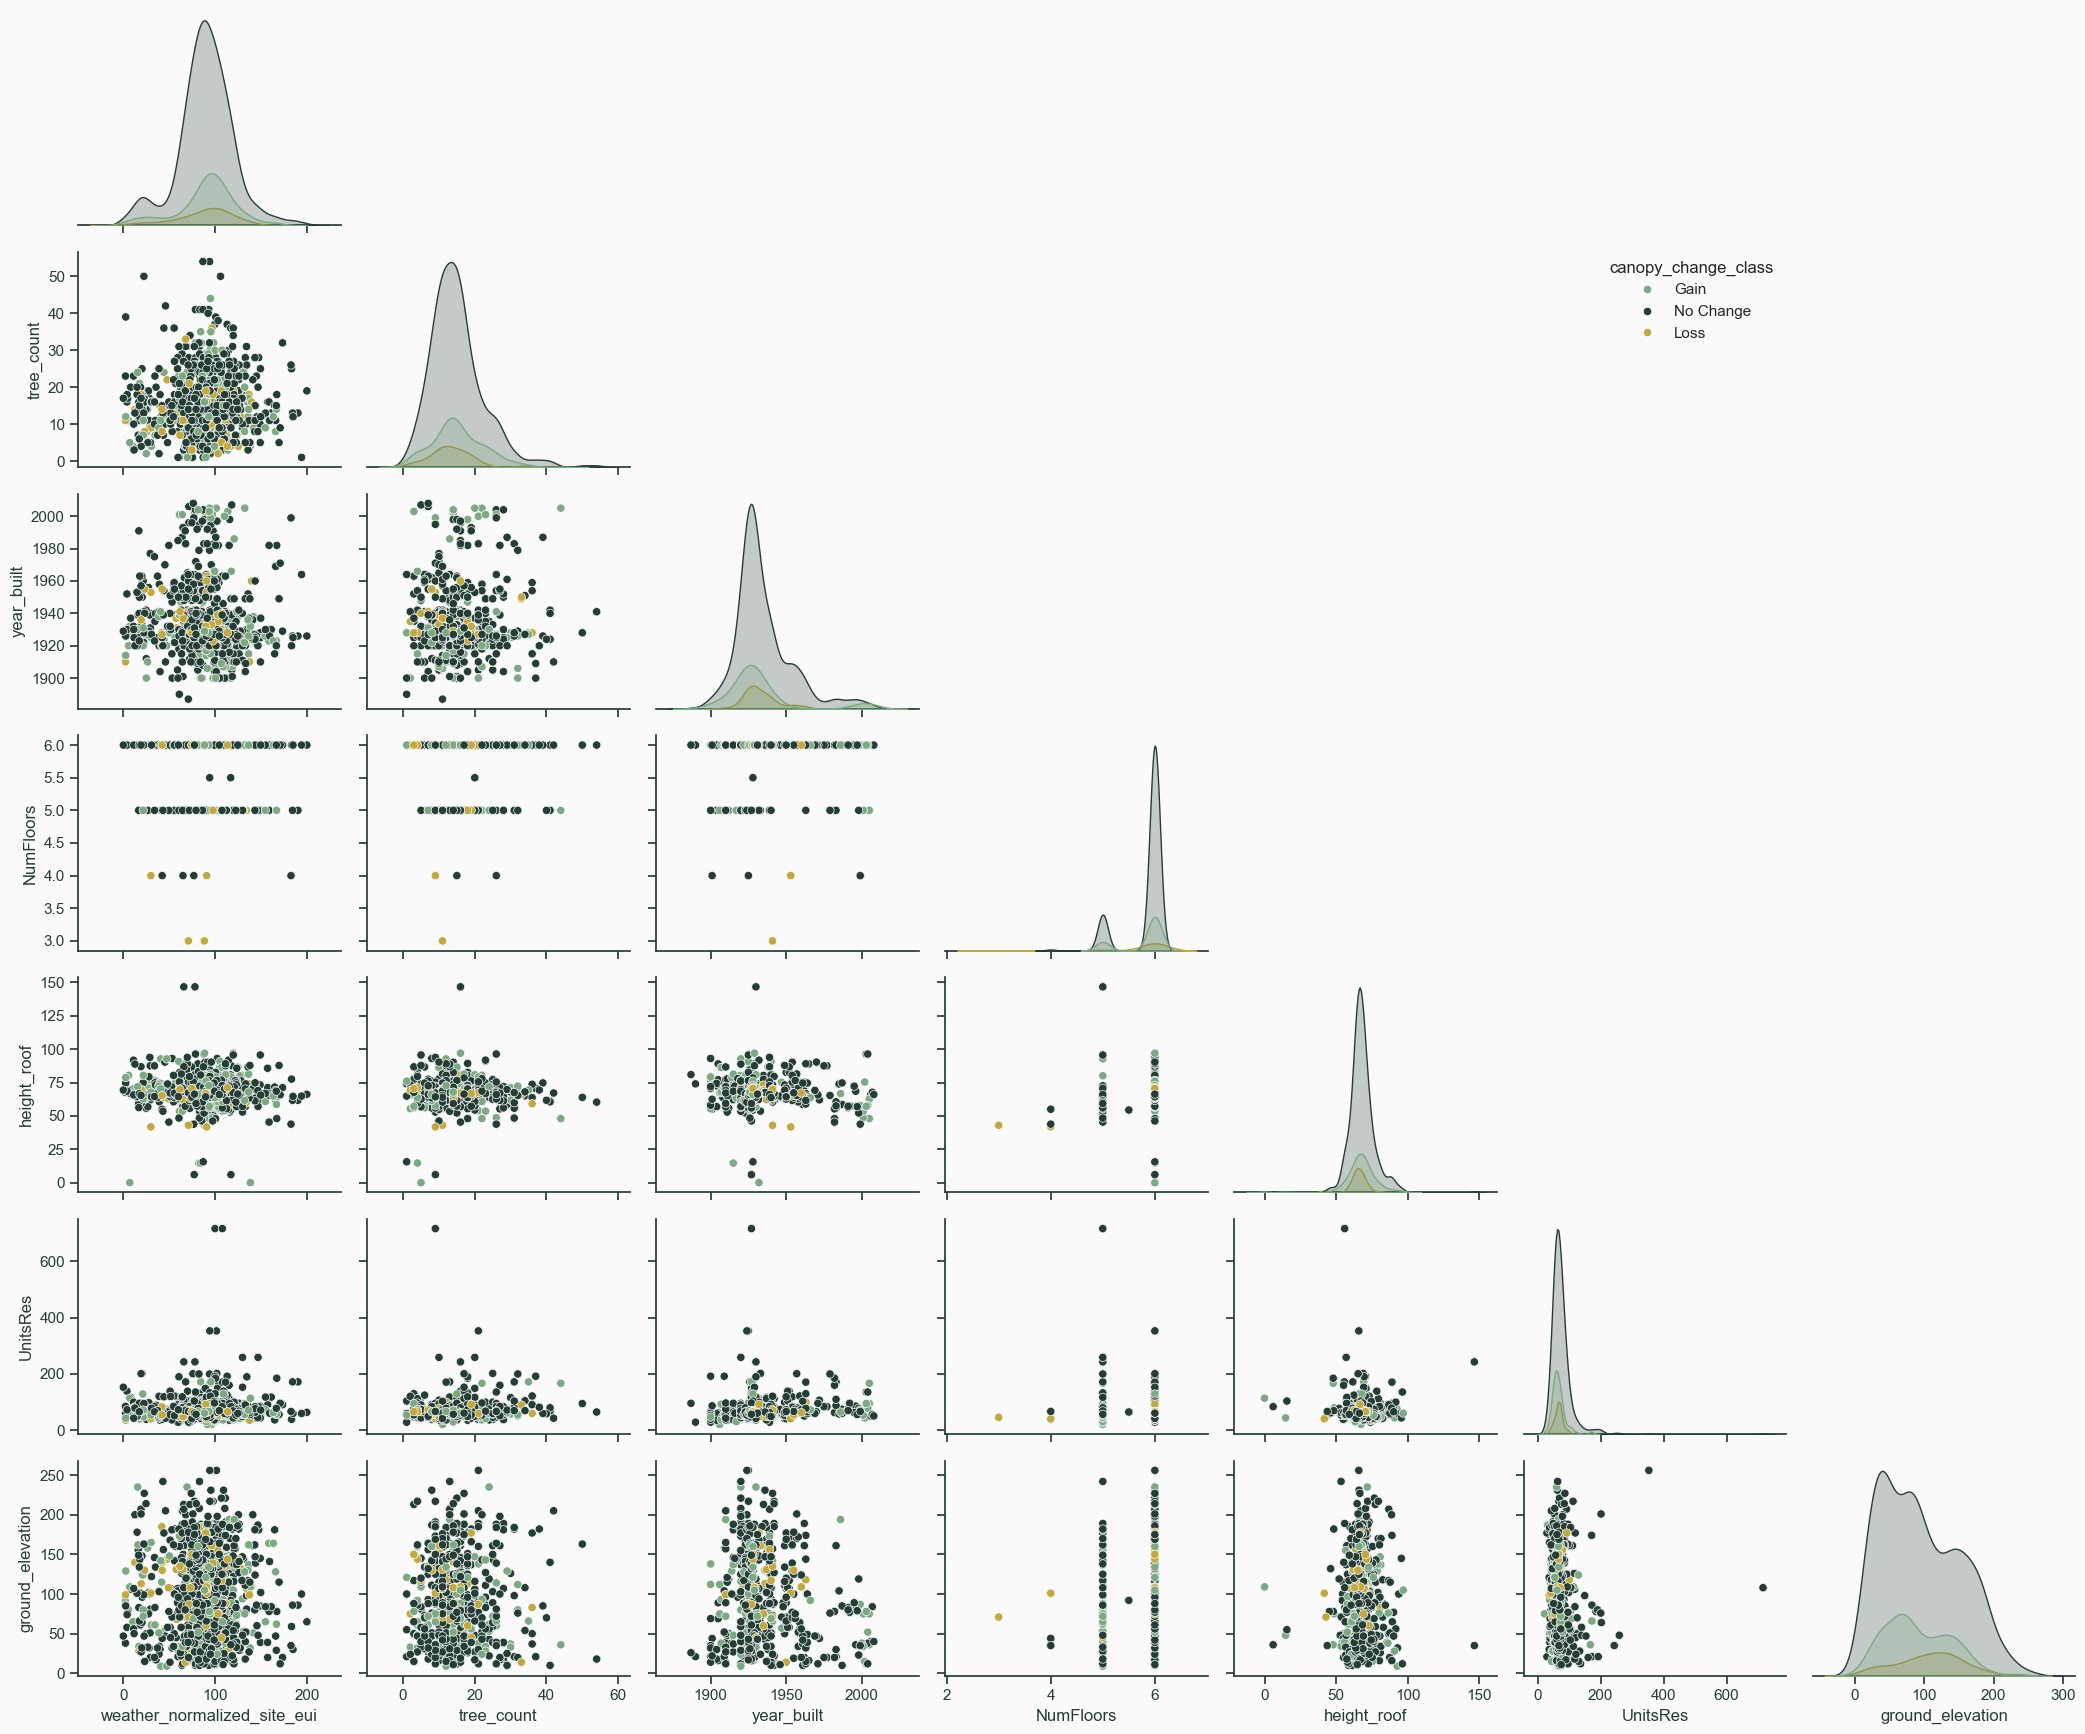

In [480]:
g = sns.pairplot(
    data=building_trees_all_lim_trees4,
    vars=pair_cols,
    hue="canopy_change_class",
    hue_order=order,
    palette=canopy_palette,
    corner=True,
    diag_kind="kde"
)

# Remove the automatically created legend
if g._legend is not None:
    g._legend.remove()

# Add a new legend in the upper-right corner of the figure
g.add_legend(
    title="Canopy Change Class",
    bbox_to_anchor=(0.85, 0.85),  # (x, y) in figure coords
    loc="upper right",            # position relative to that anchor
    borderaxespad=0
)

g.fig.tight_layout()
g.fig.savefig("fig_4_pairplot_2.png", dpi=300, bbox_inches="tight")


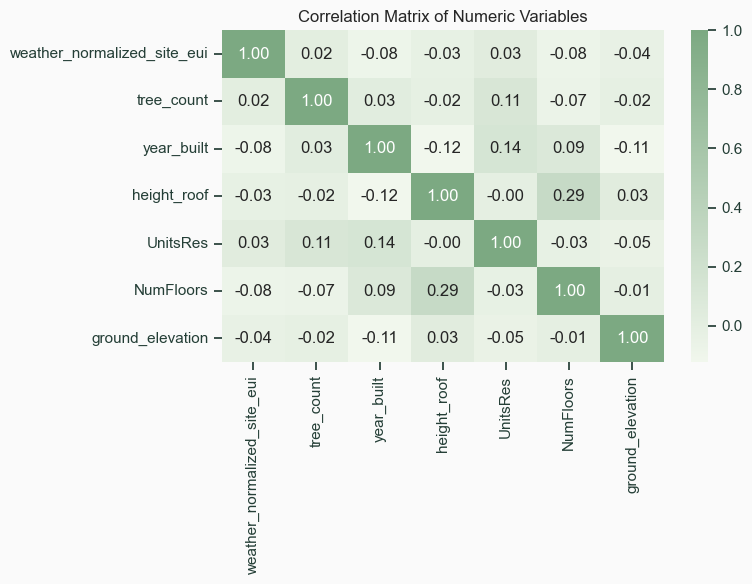

In [477]:
corr_cols = [
    "weather_normalized_site_eui",
    "tree_count",
    'year_built',
    "height_roof",
    "UnitsRes",
    "NumFloors",
    "ground_elevation"
]

corr = df[corr_cols].corr()

corr_cmap = LinearSegmentedColormap.from_list(
    "corr_cmap",
    [colors["mint_cream"],colors["muted_teal"]]
)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap=corr_cmap,
    ax=ax
)
ax.set_title("Correlation Matrix of Numeric Variables")
plt.tight_layout()


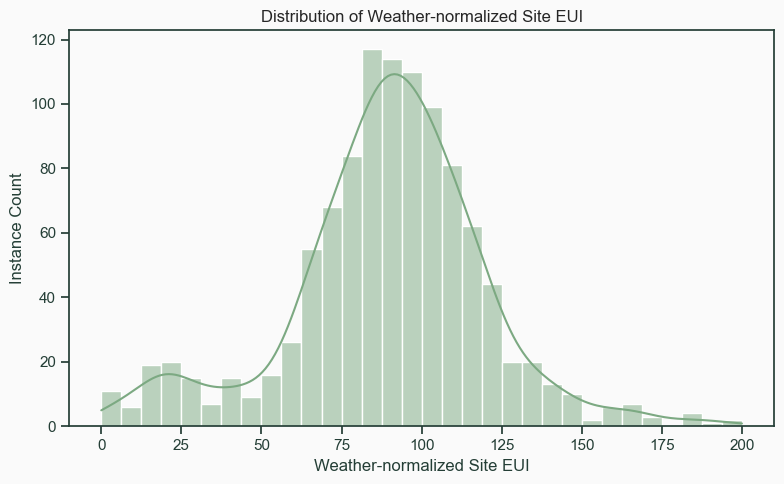

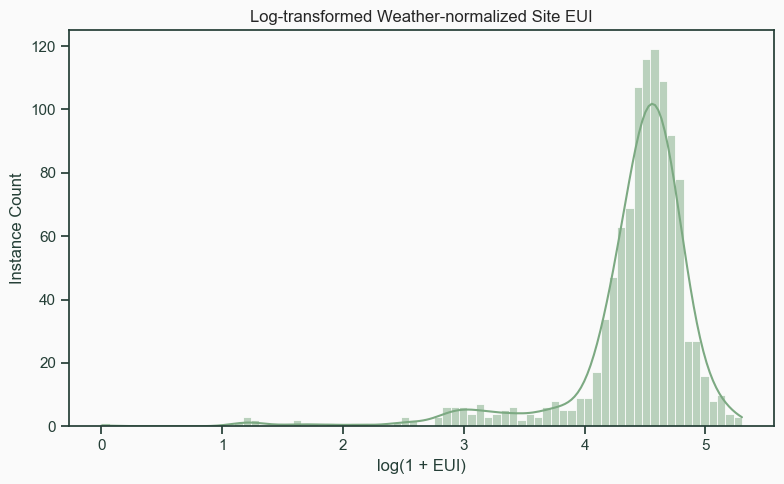

In [463]:
# Raw EUI
fig, ax = plt.subplots()
sns.histplot(
    data=building_trees_all_lim_trees4,
    x="weather_normalized_site_eui",
    kde=True,
    color=colors["muted_teal"],
    ax=ax
)
ax.set_title("Distribution of Weather-normalized Site EUI")
ax.set_xlabel("Weather-normalized Site EUI")
ax.set_ylabel("Instance Count")
plt.tight_layout()

# Log-transformed
building_trees_all_lim_trees4["log_eui"] = np.log1p(
    building_trees_all_lim_trees4["weather_normalized_site_eui"]
)

fig, ax = plt.subplots()
sns.histplot(
    data=building_trees_all_lim_trees4,
    x="log_eui",
    kde=True,
    color=colors["muted_teal"],
    ax=ax
)
ax.set_title("Log-transformed Weather-normalized Site EUI")
ax.set_xlabel("log(1 + EUI)")
ax.set_ylabel("Instance Count")
plt.tight_layout()


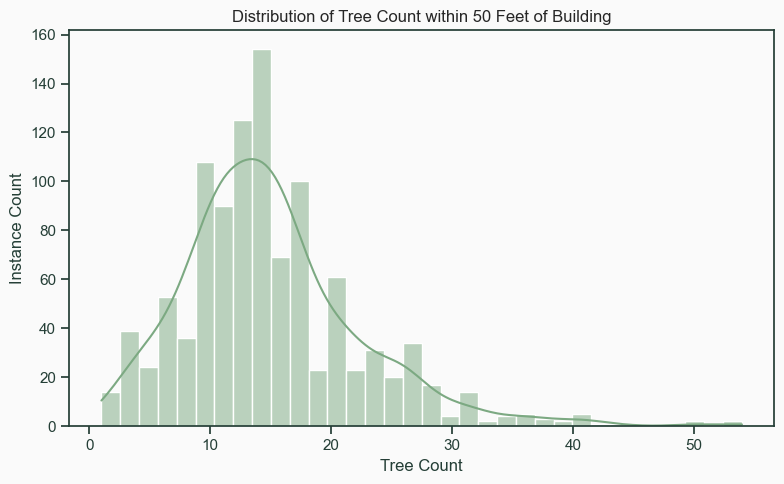

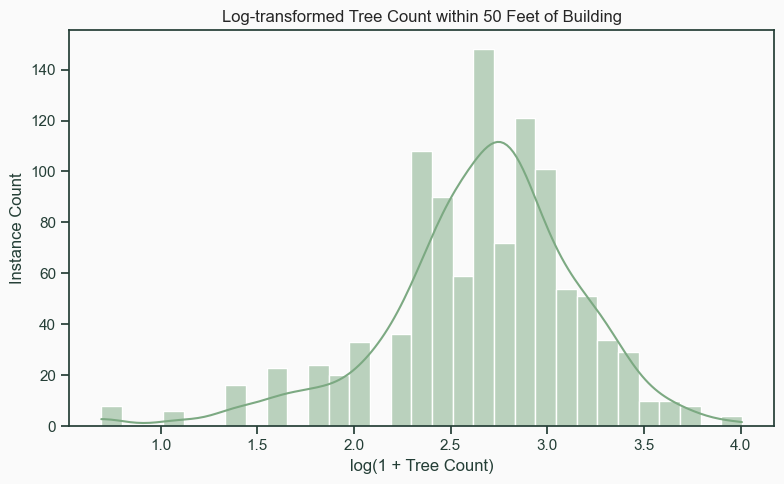

In [464]:
fig, ax = plt.subplots()
sns.histplot(
    data=building_trees_all_lim_trees4,
    x="tree_count",
    kde=True,
    color=colors["muted_teal"],
    ax=ax
)
ax.set_title("Distribution of Tree Count within 50 Feet of Building")
ax.set_ylabel("Instance Count")
ax.set_xlabel("Tree Count")
plt.tight_layout()

# Log-transformed
building_trees_all_lim_trees4["log_tree_count"] = np.log1p(
    building_trees_all_lim_trees4["tree_count"]
)

fig, ax = plt.subplots()
sns.histplot(
    data=building_trees_all_lim_trees4,
    x="log_tree_count",
    kde=True,
    color=colors["muted_teal"],
    ax=ax
)
ax.set_title("Log-transformed Tree Count within 50 Feet of Building")
ax.set_ylabel("Instance Count")
ax.set_xlabel("log(1 + Tree Count)")
plt.tight_layout()


In [ ]:
    # "mint_cream": "#F1F7ED",
    # "dark_slate_grey": "#243E36",
    # "muted_teal": "#7CA982",
    # "frosted_mint": "#E0EEC6",
    # "old_gold": "#C2A83E",

C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\3184207387.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\3184207387.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


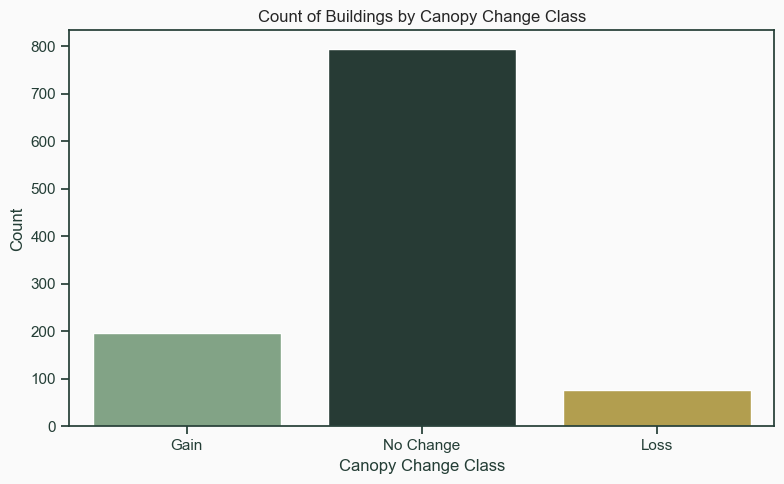

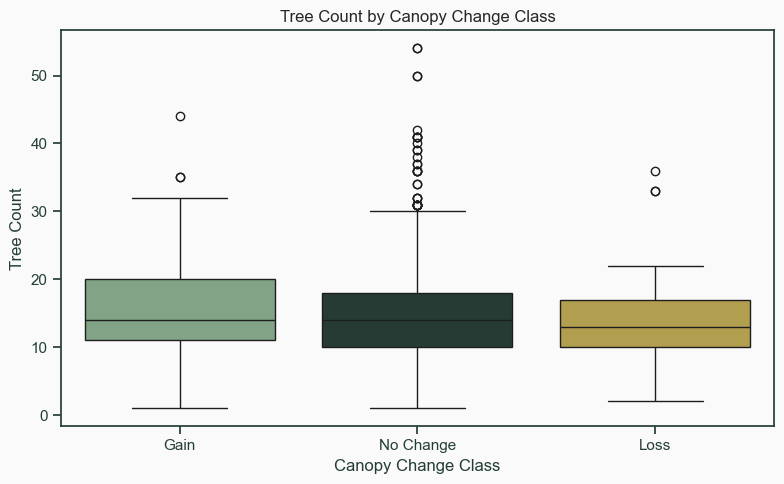

In [465]:
df = building_trees_all_lim_trees4.copy()

# Count of canopy_change_class
fig, ax = plt.subplots()
order = ["Gain", "No Change", "Loss"]
sns.countplot(
    data=df,
    x="canopy_change_class",
    order=order,
    palette=[canopy_palette[o] for o in order],
    ax=ax
)
ax.set_title("Count of Buildings by Canopy Change Class")
ax.set_xlabel("Canopy Change Class")
ax.set_ylabel("Count")
plt.tight_layout()

# Tree count by canopy_change_class
fig, ax = plt.subplots()
sns.boxplot(
    data=df,
    x="canopy_change_class",
    y="tree_count",
    order=order,
    palette=[canopy_palette[o] for o in order],
    ax=ax
)
ax.set_title("Tree Count by Canopy Change Class")
ax.set_xlabel("Canopy Change Class")
ax.set_ylabel("Tree Count")
plt.tight_layout()


C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\3062395394.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


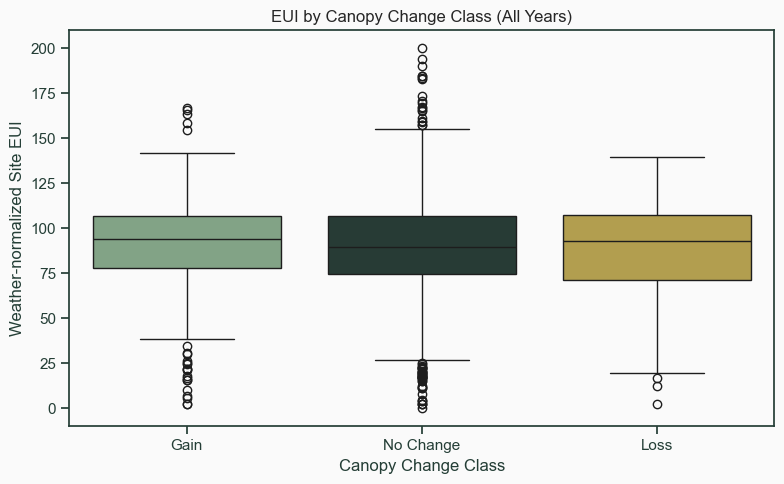

In [435]:
fig, ax = plt.subplots()
sns.boxplot(
    data=df,
    x="canopy_change_class",
    y="weather_normalized_site_eui",
    order=order,
    palette=[canopy_palette[o] for o in order],
    ax=ax
)
ax.set_title("EUI by Canopy Change Class (All Years)")
ax.set_xlabel("Canopy Change Class")
ax.set_ylabel("Weather-normalized Site EUI")
plt.tight_layout()


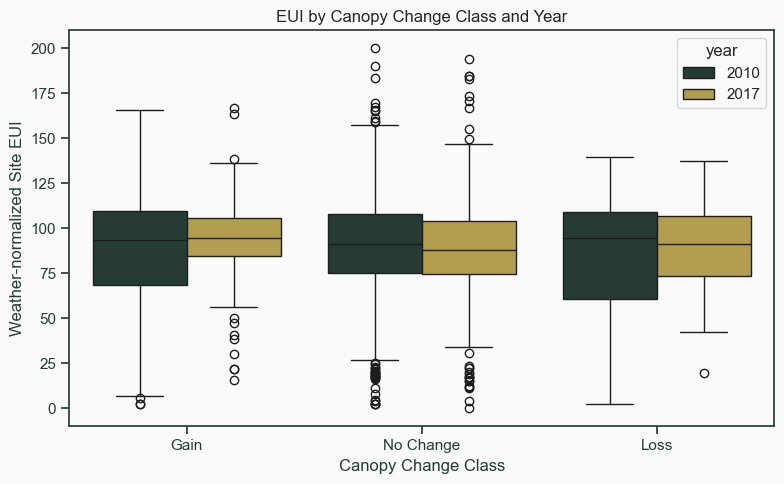

In [438]:
fig, ax = plt.subplots()
sns.boxplot(
    data=df,
    x="canopy_change_class",
    y="weather_normalized_site_eui",
    hue="year",
    order=order,
    palette=[colors["dark_slate_grey"], colors["old_gold"]],
    ax=ax
)
ax.set_title("EUI by Canopy Change Class and Year")
ax.set_xlabel("Canopy Change Class")
ax.set_ylabel("Weather-normalized Site EUI")
plt.tight_layout()


C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\3199747275.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


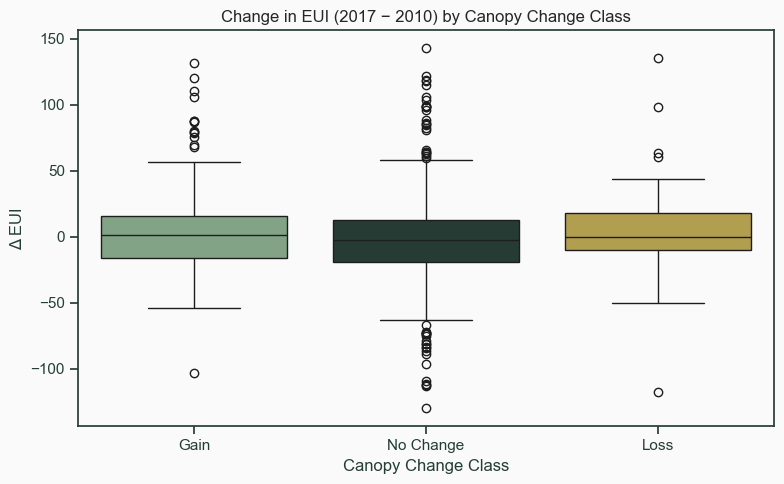

In [442]:
df_panel = df.pivot_table(
    index="bbl",
    columns="year",
    values="weather_normalized_site_eui"
).reset_index()

df_panel["delta_eui"] = df_panel[2017] - df_panel[2010]

df_panel = df_panel.merge(
    df[["bbl", "canopy_change_class"]].drop_duplicates(),
    on="bbl",
    how="left"
)

fig, ax = plt.subplots()
sns.boxplot(
    data=df_panel,
    x="canopy_change_class",
    y="delta_eui",
    order=order,
    palette=[canopy_palette[o] for o in order],
    ax=ax
)
ax.set_title("Change in EUI (2017 − 2010) by Canopy Change Class")
ax.set_xlabel("Canopy Change Class")
ax.set_ylabel("Δ EUI")
plt.tight_layout()


C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\914816135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\914816135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\914816135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\914816135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

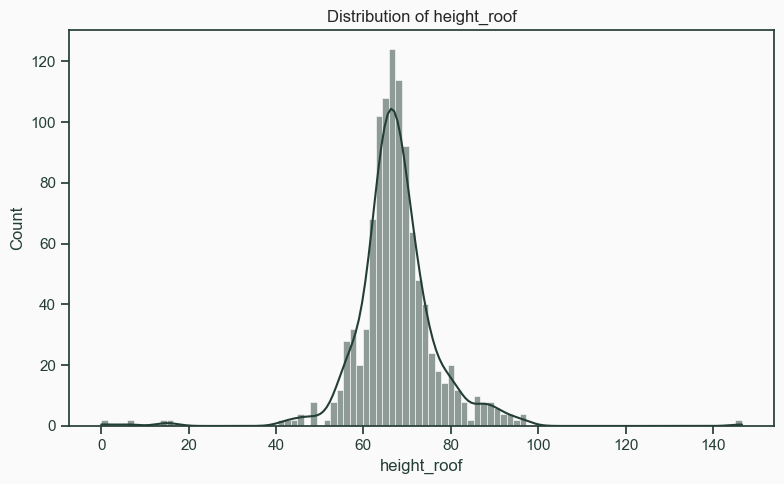

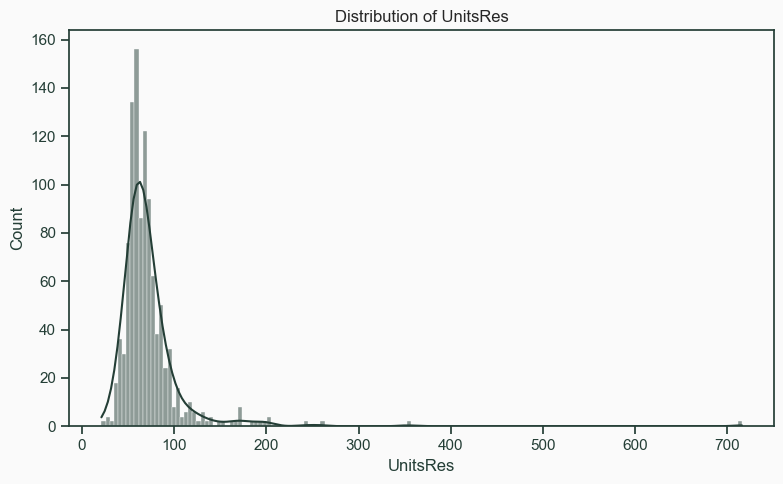

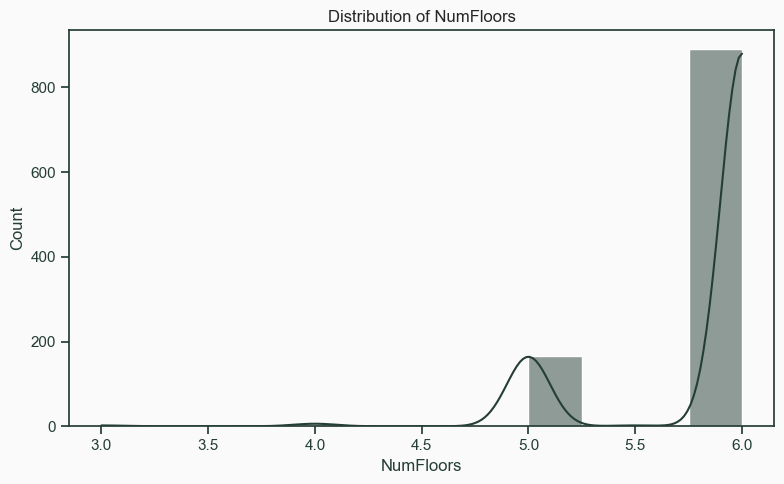

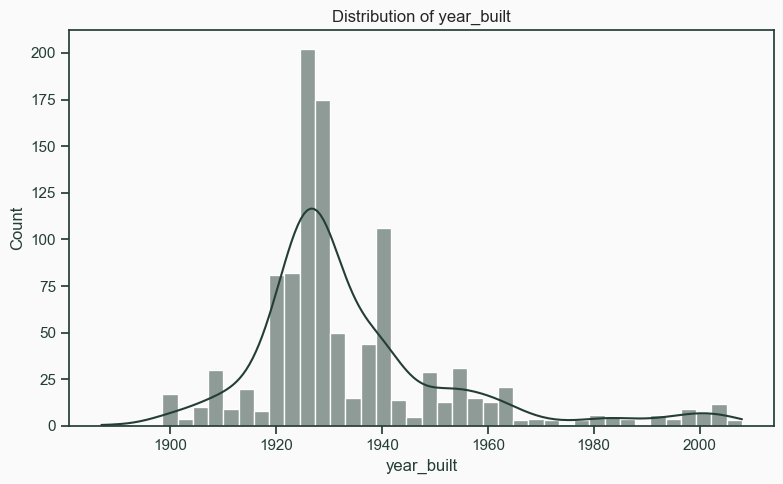

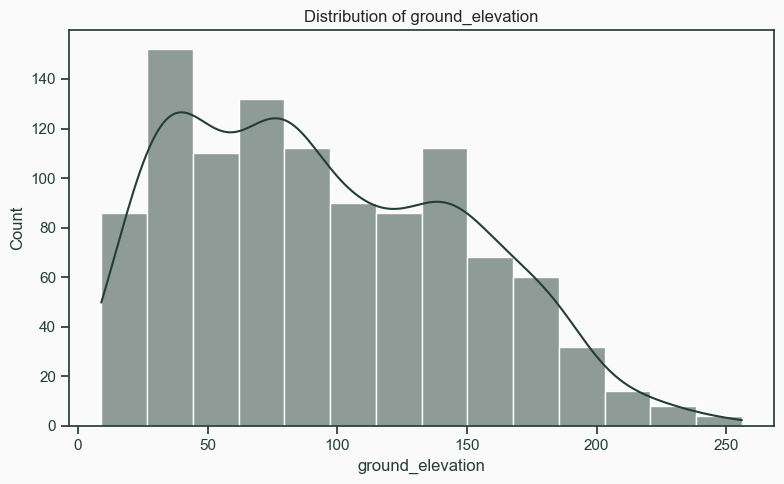

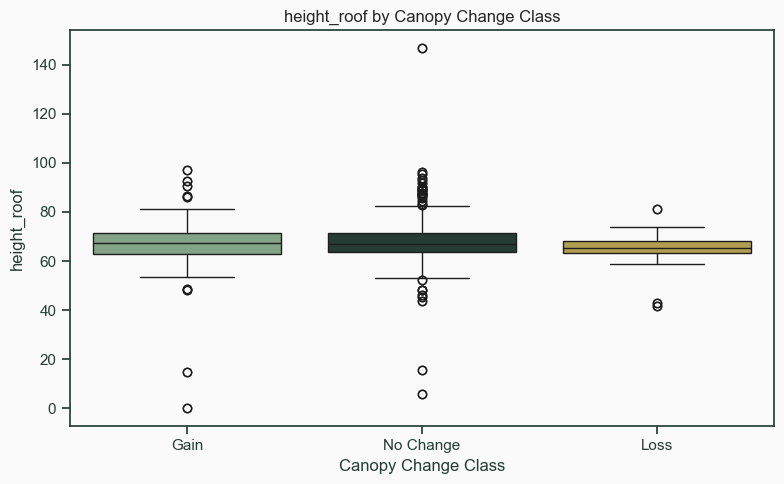

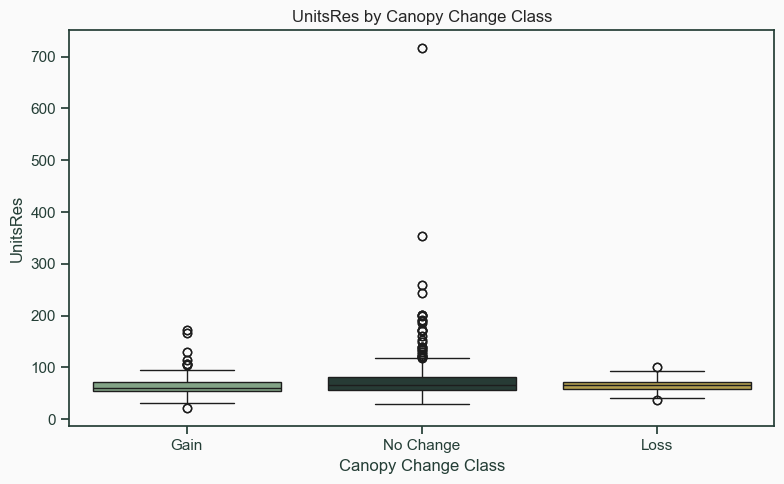

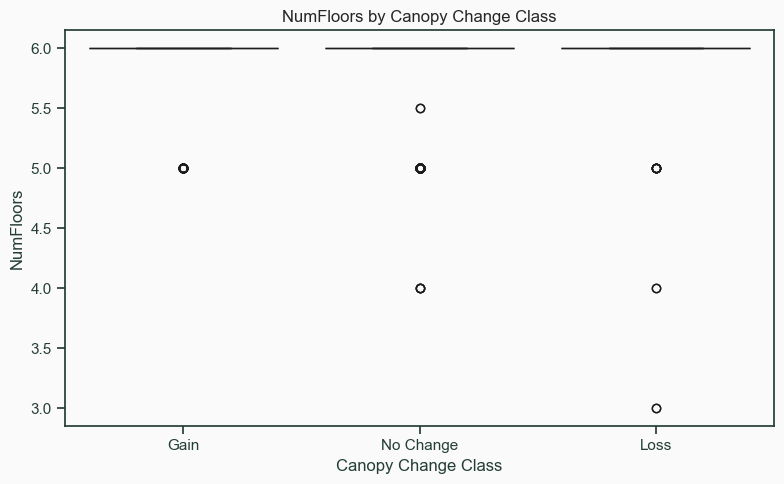

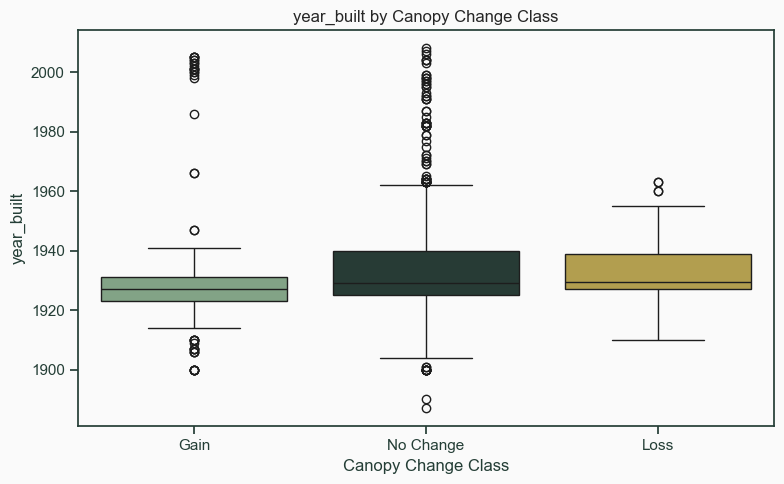

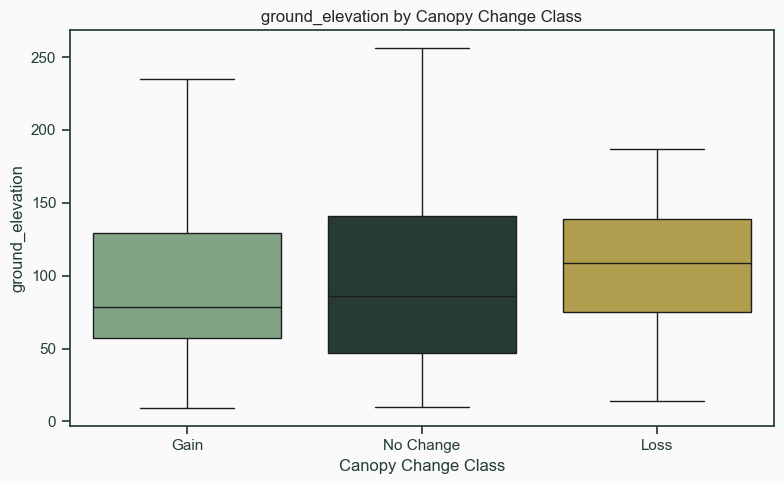

In [444]:
num_cols = ["height_roof", "UnitsRes", "NumFloors", "year_built", "ground_elevation"]

# Overall distributions
for col in num_cols:
    fig, ax = plt.subplots()
    sns.histplot(
        data=df,
        x=col,
        kde=True,
        color=colors["dark_slate_grey"],
        ax=ax
    )
    ax.set_title(f"Distribution of {col}")
    plt.tight_layout()

# By canopy class
for col in num_cols:
    fig, ax = plt.subplots()
    sns.boxplot(
        data=df,
        x="canopy_change_class",
        y=col,
        order=order,
        palette=[canopy_palette[o] for o in order],
        ax=ax
    )
    ax.set_title(f"{col} by Canopy Change Class")
    ax.set_xlabel("Canopy Change Class")
    ax.set_ylabel(col)
    plt.tight_layout()


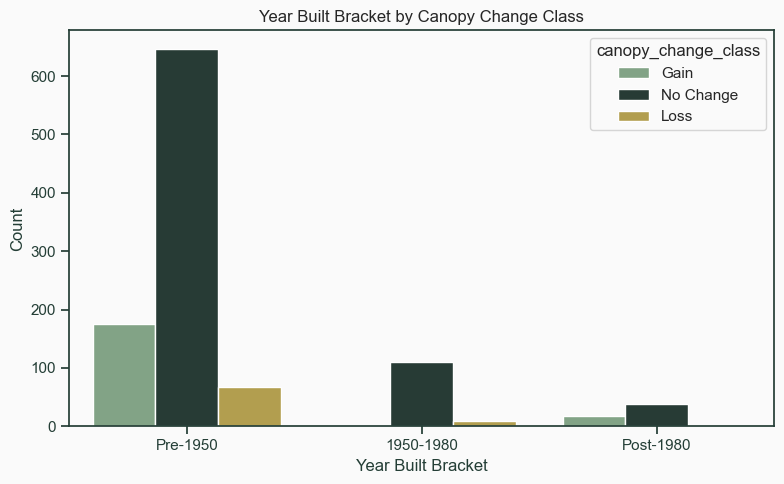

In [455]:
fig, ax = plt.subplots()
sns.countplot(
    data=df,
    x="year_built_bracket",
    hue="canopy_change_class",
    hue_order=order,
    palette=[canopy_palette[o] for o in order],
    ax=ax
)
ax.set_title("Year Built Bracket by Canopy Change Class")
ax.set_xlabel("Year Built Bracket")
ax.set_ylabel("Count")
# plt.xticks(rotation=45)
plt.tight_layout()


In [459]:
df.columns

Index(['year', 'ct2010', 'bbl', 'year_built', 'BldgClass', 'NumFloors',
       'canopy_change_class', 'UnitsRes', 'ground_elevation', 'height_roof',
       'weather_normalized_site_eui', 'tree_count', 'year_built_bracket',
       'commercial_floor_flag', 'log_eui'],
      dtype='object')

In [447]:
colors

{'mint_cream': '#F1F7ED',
 'dark_slate_grey': '#243E36',
 'muted_teal': '#7CA982',
 'frosted_mint': '#E0EEC6',
 'old_gold': '#C2A83E'}

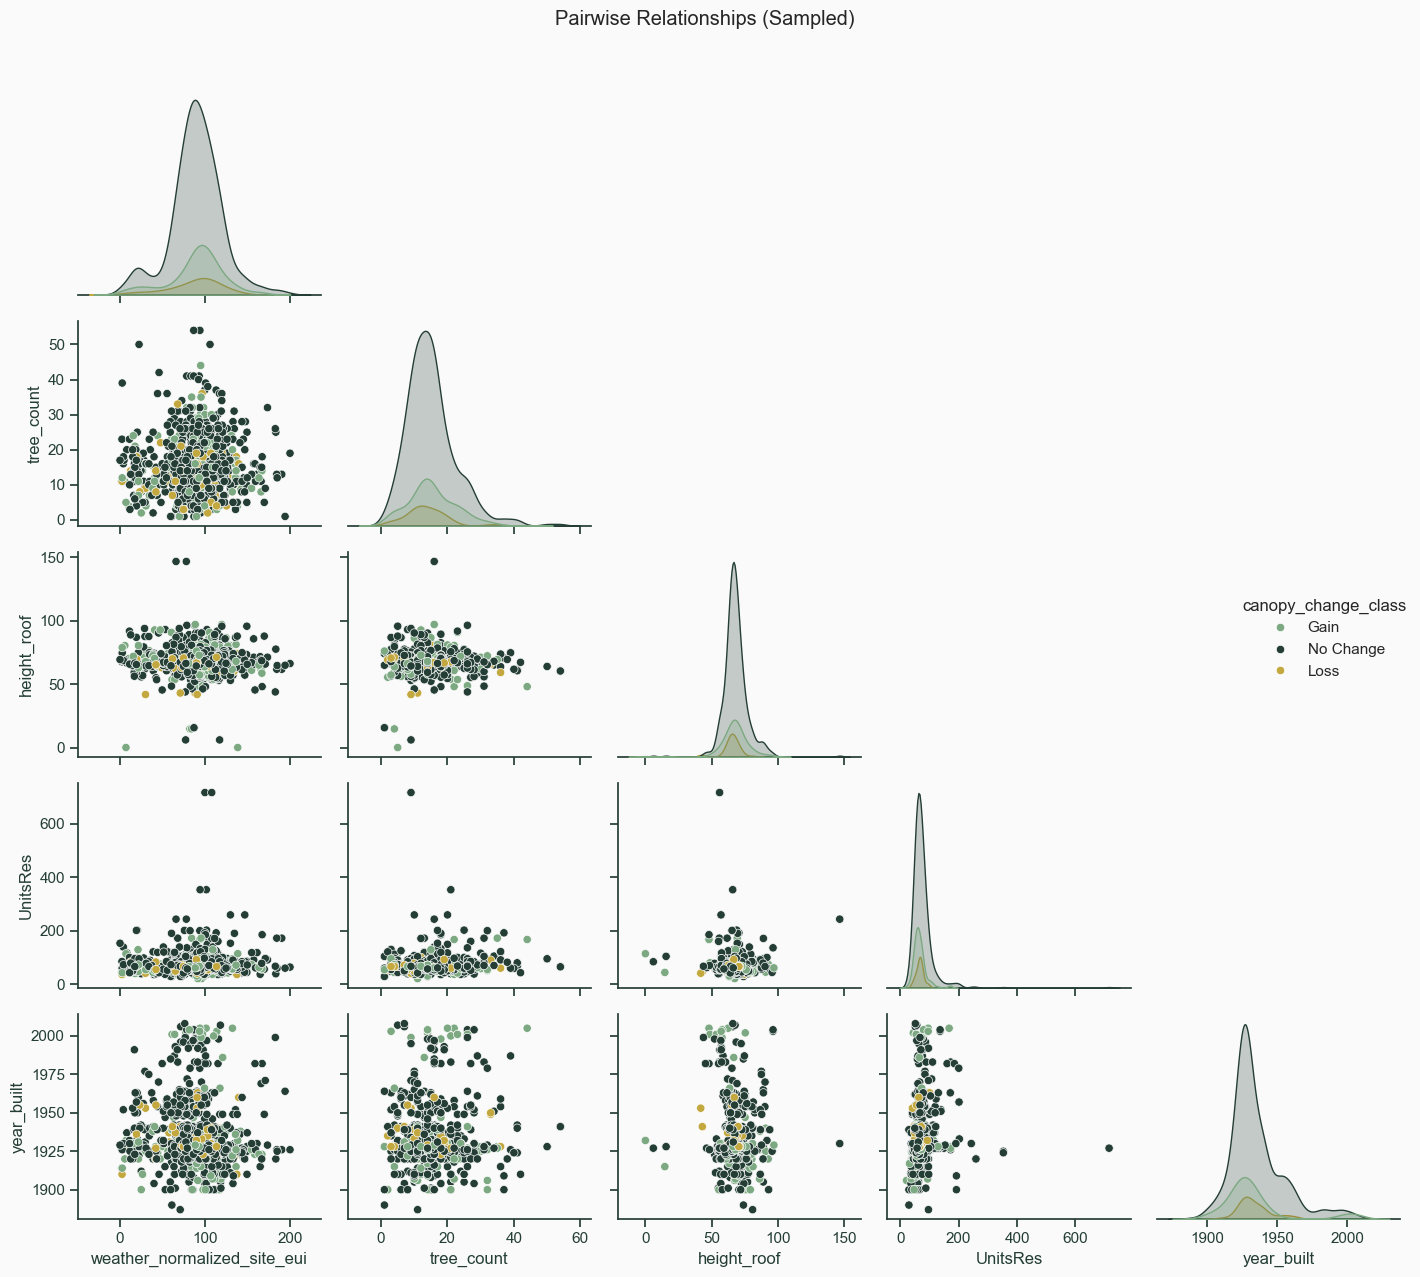

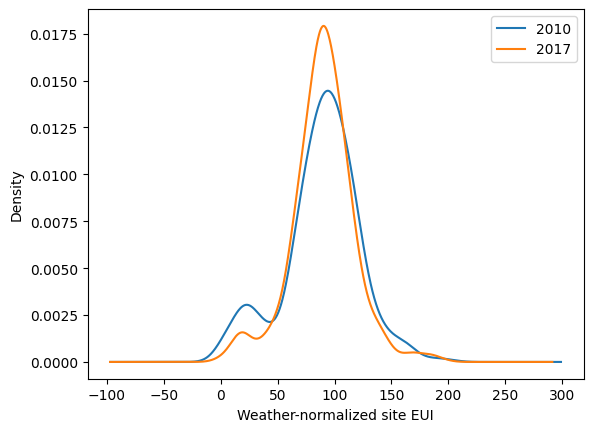

In [274]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for y in [2010, 2017]:
    subset = df[df['year'] == y]['weather_normalized_site_eui']
    subset.plot(kind='kde', ax=ax, label=str(y))
ax.set_xlabel("Weather-normalized site EUI")
ax.legend()
plt.show()


In [226]:

print(building_trees_all_lim_trees_eui_extremes.shape)


(2725, 12)
(2693, 12)


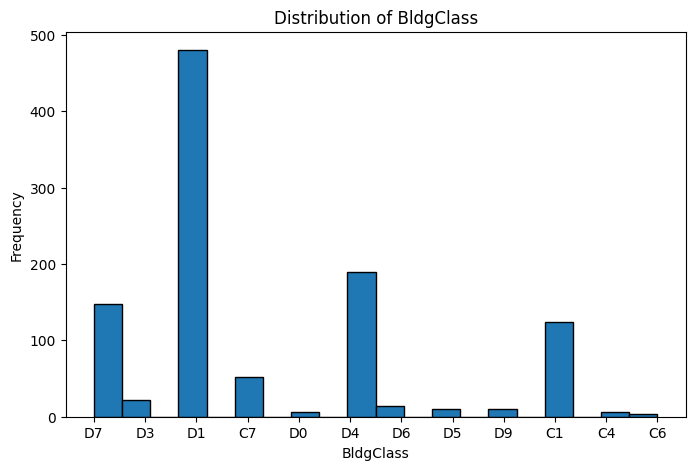

In [252]:
##### Break down of builkding coutns for each Zoneing Class
plt.figure(figsize=(8, 5))
plt.hist(building_trees_all_lim_trees4["BldgClass"], bins=20, edgecolor="black")
plt.xlabel("BldgClass")
plt.ylabel("Frequency")
plt.title("Distribution of BldgClass")
# plt.grid(axis="y", alpha=0.75)
plt.show()

In [257]:
test = building_trees_all_lim_trees4.groupby(['year','ct2010']).agg({'bbl':"nunique"}).reset_index()
test.sort_values("bbl",ascending= False)

,year,ct2010,bbl
338,2017,29500,19
144,2010,29500,19
131,2010,27300,16
325,2017,27300,16
329,2017,27900,13
...,...,...,...
196,2017,2500,1
197,2017,3001,1
198,2017,3100,1
199,2017,3500,1


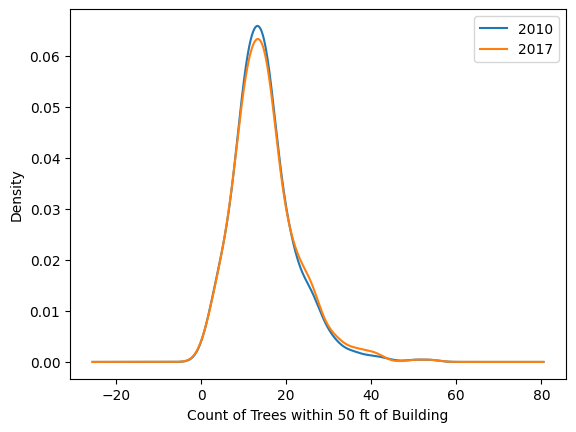

In [288]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for y in [2010, 2017]:
    subset = df[df['year'] == y]['tree_count']
    subset.plot(kind='kde', ax=ax, label=str(y))
ax.set_xlabel("Count of Trees within 50 ft of Building")
ax.legend()
plt.show()


In [258]:
##### Break down of builkding coutns for each Census Tract
import io
import requests
import geopandas as gpd
import matplotlib.pyplot as plt

# Download CT2010 from NYC Open Data as GeoJSON
CT2010_URL = "https://data.cityofnewyork.us/resource/bmjq-373p.geojson?$limit=50000"
resp = requests.get(CT2010_URL, timeout=60)
resp.raise_for_status()

# Read into GeoDataFrame and project to EPSG:2263
ct2010 = gpd.read_file(io.BytesIO(resp.content)).to_crs(2263)

# Quick look
ct2010.head()


,ntacode,shape_area,ntaname,shape_leng,boroname,puma,boroct2010,ct2010,borocode,cdeligibil,ctlabel,geometry
0,SI22,2497009.71359,West New Brighton-New Brighton-St. George,7729.01679383,Staten Island,3903,5000900,000900,5,E,9,"MULTIPOLYGON (((962269.126 173705.5, 962288.72..."
1,MN17,1860992.68163,Midtown-Midtown South,5687.80243891,Manhattan,3807,1010200,010200,1,I,102,"MULTIPOLYGON (((992216.539 216507.687, 992091...."
2,MN17,1864600.43538,Midtown-Midtown South,5693.03636707,Manhattan,3807,1010400,010400,1,I,104,"MULTIPOLYGON (((991325.882 217001.689, 991199...."
3,MN17,1890907.25105,Midtown-Midtown South,5699.86064037,Manhattan,3807,1011300,011300,1,I,113,"MULTIPOLYGON (((988650.277 214286.402, 988517...."
4,MN40,1918144.56374,Upper East Side-Carnegie Hill,5807.97295649,Manhattan,3805,1013000,013000,1,I,130,"MULTIPOLYGON (((994920.11 221386.27, 994791.85..."


In [268]:
# building_trees_all_lim_trees4.to_csv("building_trees_all_lim_trees4.csv",index=False)

In [301]:
#Looking at Energy Values 
print(building_trees_all_lim_trees4.groupby(["year","canopy_change_class"])["weather_normalized_site_eui"].describe())
print(building_trees_all_lim_trees4.groupby(["year","canopy_change_class"])["tree_count"].describe())

                          count       mean        std   min     25%    50%  \
year canopy_change_class                                                     
2010 Gain                  98.0  86.437755  37.037912   2.2  68.275  93.75   
     Loss                  38.0  84.255263  35.882448   2.4  60.525  94.85   
     No Change            397.0  89.875567  32.432311   2.3  75.000  91.50   
2017 Gain                  98.0  92.992857  25.943204  15.6  84.650  94.35   
     Loss                  38.0  90.560526  24.606344  19.4  73.425  91.40   
     No Change            397.0  88.951511  28.218920   0.0  74.800  88.00   

                              75%    max  
year canopy_change_class                  
2010 Gain                 109.850  165.9  
     Loss                 108.900  139.7  
     No Change            108.100  200.0  
2017 Gain                 105.850  166.9  
     Loss                 106.975  137.5  
     No Change            104.000  194.2  
                          count

#### PreModeling - Get a Sense of thigns 

In [302]:
building_trees_all_lim_trees4.groupby(['canopy_change_class','year'])['weather_normalized_site_eui'].mean().unstack()

year,2010,2017
canopy_change_class,,
Gain,86.437755,92.992857
Loss,84.255263,90.560526
No Change,89.875567,88.951511


In [307]:
modeling_df = building_trees_all_lim_trees4.copy()

# Post indicator: 0 for 2010, 1 for 2017
modeling_df['post'] = (modeling_df['year'] == 2017).astype(int)

# Treatment dummies from canopy change:
modeling_df['gain'] = (modeling_df['canopy_change_class'] == 'Gain').astype(int)
modeling_df['loss'] = (modeling_df['canopy_change_class'] == 'Loss').astype(int)
# Reference group (control) is 'No Change' (both gain=0, loss=0)

modeling_df[['year','canopy_change_class','post','gain','loss']].sample(n=10)

,year,canopy_change_class,post,gain,loss
1164,2010,No Change,0,0,0
959,2010,No Change,0,0,0
2358,2017,No Change,1,0,0
932,2010,Loss,0,0,1
2242,2017,No Change,1,0,0
2269,2017,No Change,1,0,0
1179,2010,No Change,0,0,0
1089,2010,Loss,0,0,1
1223,2010,Loss,0,0,1
2472,2017,No Change,1,0,0


In [309]:
# Average EUI by canopy-change group and year
table_eui = modeling_df.groupby(['canopy_change_class', 'year'])['weather_normalized_site_eui'] \
              .agg(['count', 'mean','median', 'std']) \
              .reset_index()

table_eui


,canopy_change_class,year,count,mean,median,std
0,Gain,2010,98,86.437755,93.75,37.037912
1,Gain,2017,98,92.992857,94.35,25.943204
2,Loss,2010,38,84.255263,94.85,35.882448
3,Loss,2017,38,90.560526,91.40,24.606344
4,No Change,2010,397,89.875567,91.50,32.432311
5,No Change,2017,397,88.951511,88.00,28.218920


In [311]:
table_trees = modeling_df.groupby(['canopy_change_class','year'])['tree_count'] \
                .agg(['count','mean','median','std']) \
                .reset_index()

table_trees


,canopy_change_class,year,count,mean,median,std
0,Gain,2010,98,15.153061,14.0,7.436816
1,Gain,2017,98,15.561224,14.5,7.345756
2,Loss,2010,38,13.315789,13.0,5.863793
3,Loss,2017,38,13.789474,13.0,6.889702
4,No Change,2010,397,14.939547,14.0,7.373949
5,No Change,2017,397,15.206549,14.0,7.713798


In [312]:
# Make a wide table: rows = buildings, columns = year-specific values
wide = modeling_df.pivot(index='bbl',
                columns='year',
                values=['weather_normalized_site_eui', 'tree_count'])

# Clean up the column names
wide.columns = ['eui_2010', 'eui_2017', 'trees_2010', 'trees_2017']

# Compute changes: 2017 minus 2010
wide['delta_eui'] = wide['eui_2017'] - wide['eui_2010']
wide['delta_trees'] = wide['trees_2017'] - wide['trees_2010']

wide.head()


,eui_2010,eui_2017,trees_2010,trees_2017,delta_eui,delta_trees
bbl,,,,,,
1003450048,67.7,67.9,31.0,31.0,0.2,0.0
1004110045,25.0,103.4,2.0,2.0,78.4,0.0
1004620035,71.3,74.7,16.0,16.0,3.4,0.0
1004950011,101.9,97.1,5.0,5.0,-4.8,0.0
1005000005,61.0,59.6,1.0,1.0,-1.4,0.0


In [313]:
# Take 2010 rows to grab building-level info (same in both years)
base_2010 = modeling_df[modeling_df['year'] == 2010].set_index('bbl')

# We care about canopy_change_class for now (more later)
wide = wide.join(base_2010[['canopy_change_class']])

wide.head()


,eui_2010,eui_2017,trees_2010,trees_2017,delta_eui,delta_trees,canopy_change_class
bbl,,,,,,,
1003450048,67.7,67.9,31.0,31.0,0.2,0.0,No Change
1004110045,25.0,103.4,2.0,2.0,78.4,0.0,Gain
1004620035,71.3,74.7,16.0,16.0,3.4,0.0,No Change
1004950011,101.9,97.1,5.0,5.0,-4.8,0.0,Gain
1005000005,61.0,59.6,1.0,1.0,-1.4,0.0,No Change


In [314]:
wide.groupby('canopy_change_class')['delta_eui'].describe()


,count,mean,std,min,25%,50%,75%,max
canopy_change_class,,,,,,,,
Gain,98.0,6.555102,41.370368,-103.0,-16.15,1.05,15.750,131.5
Loss,38.0,6.305263,41.044122,-117.5,-9.65,-0.20,18.175,135.1
No Change,397.0,-0.924055,37.475022,-129.9,-18.80,-2.20,12.400,142.8


In [318]:
### only Lookign at Canopy change diffferenc-in-difference start
wide = wide.copy()

wide['gain'] = (wide['canopy_change_class'] == 'Gain').astype(int)
wide['loss'] = (wide['canopy_change_class'] == 'Loss').astype(int)

wide[['canopy_change_class','gain','loss']].sample(n=5)



,canopy_change_class,gain,loss
bbl,,,
2026030035,Gain,1,0
2033180052,Loss,0,1
1021360175,No Change,0,0
2024860030,Gain,1,0
1021700134,No Change,0,0


### Modeling Start - Canopy Change And EUI 1

In [319]:
import statsmodels.api as sm

# Our outcome is the change in EUI
y = wide['delta_eui']

# Our explanatory variables are gain and loss (No Change is baseline)
X = wide[['gain','loss']]

# Add a constant term (the intercept alpha)
X = sm.add_constant(X)

# Fit the linear model
model_canopy = sm.OLS(y, X).fit()

print(model_canopy.summary())


                            OLS Regression Results                            
Dep. Variable:              delta_eui   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.879
Date:                Sat, 22 Nov 2025   Prob (F-statistic):              0.154
Time:                        14:33:24   Log-Likelihood:                -2700.2
No. Observations:                 533   AIC:                             5406.
Df Residuals:                     530   BIC:                             5419.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9241      1.931     -0.479      0.6

In [320]:
alpha = model_canopy.params['const']
beta_gain = model_canopy.params['gain']

mean_delta_eui_gain = alpha + beta_gain
mean_delta_eui_gain
##OUTPUT: 6.555102040816311

6.555102040816311

In [ ]:
# Model 2 - 

In [321]:
wide[['trees_2010','trees_2017','delta_trees']].head()
wide['delta_trees'].describe()


count    533.000000
mean       0.307692
std        3.378820
min      -22.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       21.000000
Name: delta_trees, dtype: float64

In [322]:
# Outcome: change in EUI
y = wide['delta_eui']

# Explanatory variables: gain, loss, and change in tree count
X = wide[['gain', 'loss', 'delta_trees']]
X = sm.add_constant(X)

model_trees = sm.OLS(y, X).fit()

print(model_trees.summary())


                            OLS Regression Results                            
Dep. Variable:              delta_eui   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.250
Date:                Sat, 22 Nov 2025   Prob (F-statistic):              0.291
Time:                        14:44:04   Log-Likelihood:                -2700.2
No. Observations:                 533   AIC:                             5408.
Df Residuals:                     529   BIC:                             5426.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.9230      1.937     -0.476      

count    533.000000
mean       0.966510
std       38.536268
min     -129.900000
25%      -17.800000
50%       -1.400000
75%       13.600000
max      142.800000
Name: delta_eui, dtype: float64


,eui_2010,eui_2017,delta_eui
bbl,,,
1003450048,67.7,67.9,0.2
1004110045,25.0,103.4,78.4
1004620035,71.3,74.7,3.4
1004950011,101.9,97.1,-4.8
1005000005,61.0,59.6,-1.4
...,...,...,...
2057990032,93.4,86.4,-7.0
2058000001,44.2,64.2,20.0
2058021294,85.5,98.9,13.4


In [ ]:
### The results of these models are not as we expect, one variable can think of is the rapid turn over of business types on the first floor c
### can wee control for this by looking at only those buildings that arent zoned for the first floor commercial

In [330]:
#Checking that the numbers are still decent 
building_trees_all_lim_trees4.groupby(['commercial_floor_flag']).agg({'bbl':'nunique'})

,bbl
commercial_floor_flag,
0,426
1,107


In [331]:
## Doing the dame models with those buildigns that, according to zoning types, dont have stores
no_stores_buildings = building_trees_all_lim_trees4[building_trees_all_lim_trees4["commercial_floor_flag"]==0]

In [332]:
no_stores_buildings.groupby(['canopy_change_class','year'])['weather_normalized_site_eui'].mean().unstack()

year,2010,2017
canopy_change_class,,
Gain,80.357746,90.507746
Loss,86.830000,90.536667
No Change,90.049385,88.200615


In [333]:
modeling_df = no_stores_buildings.copy()

# Post indicator: 0 for 2010, 1 for 2017
modeling_df['post'] = (modeling_df['year'] == 2017).astype(int)

# Treatment dummies from canopy change:
modeling_df['gain'] = (modeling_df['canopy_change_class'] == 'Gain').astype(int)
modeling_df['loss'] = (modeling_df['canopy_change_class'] == 'Loss').astype(int)
# Reference group (control) is 'No Change' (both gain=0, loss=0)

modeling_df[['year','canopy_change_class','post','gain','loss']].sample(n=10)

,year,canopy_change_class,post,gain,loss
165,2010,No Change,0,0,0
2125,2017,Loss,1,0,1
2227,2017,No Change,1,0,0
1123,2010,No Change,0,0,0
2259,2017,No Change,1,0,0
2491,2017,No Change,1,0,0
2313,2017,No Change,1,0,0
448,2010,No Change,0,0,0
1214,2010,Gain,0,1,0
498,2010,No Change,0,0,0


In [334]:
# Average EUI by canopy-change group and year
table_eui = modeling_df.groupby(['canopy_change_class', 'year'])['weather_normalized_site_eui'] \
              .agg(['count', 'mean','median', 'std']) \
              .reset_index()

table_eui


,canopy_change_class,year,count,mean,median,std
0,Gain,2010,71,80.357746,89.50,37.787604
1,Gain,2017,71,90.507746,93.80,25.317711
2,Loss,2010,30,86.830000,94.85,34.320358
3,Loss,2017,30,90.536667,91.40,22.856426
4,No Change,2010,325,90.049385,91.50,31.910238
5,No Change,2017,325,88.200615,86.90,28.036683


In [335]:
table_trees = modeling_df.groupby(['canopy_change_class','year'])['tree_count'] \
                .agg(['count','mean','median','std']) \
                .reset_index()

table_trees


,canopy_change_class,year,count,mean,median,std
0,Gain,2010,71,15.859155,15.0,7.556068
1,Gain,2017,71,16.183099,15.0,7.370423
2,Loss,2010,30,13.566667,13.5,6.234959
3,Loss,2017,30,14.166667,13.5,7.428200
4,No Change,2010,325,14.655385,14.0,7.489376
5,No Change,2017,325,15.033846,14.0,7.871387


In [336]:
# Make a wide table: rows = buildings, columns = year-specific values
wide = modeling_df.pivot(index='bbl',
                columns='year',
                values=['weather_normalized_site_eui', 'tree_count'])

# Clean up the column names
wide.columns = ['eui_2010', 'eui_2017', 'trees_2010', 'trees_2017']

# Compute changes: 2017 minus 2010
wide['delta_eui'] = wide['eui_2017'] - wide['eui_2010']
wide['delta_trees'] = wide['trees_2017'] - wide['trees_2010']

wide.head()


,eui_2010,eui_2017,trees_2010,trees_2017,delta_eui,delta_trees
bbl,,,,,,
1003450048,67.7,67.9,31.0,31.0,0.2,0.0
1004110045,25.0,103.4,2.0,2.0,78.4,0.0
1004620035,71.3,74.7,16.0,16.0,3.4,0.0
1005000005,61.0,59.6,1.0,1.0,-1.4,0.0
1005320020,65.9,78.0,16.0,16.0,12.1,0.0


In [337]:
# Take 2010 rows to grab building-level info (same in both years)
base_2010 = modeling_df[modeling_df['year'] == 2010].set_index('bbl')

# We care about canopy_change_class for now (more later)
wide = wide.join(base_2010[['canopy_change_class']])

wide.head()


,eui_2010,eui_2017,trees_2010,trees_2017,delta_eui,delta_trees,canopy_change_class
bbl,,,,,,,
1003450048,67.7,67.9,31.0,31.0,0.2,0.0,No Change
1004110045,25.0,103.4,2.0,2.0,78.4,0.0,Gain
1004620035,71.3,74.7,16.0,16.0,3.4,0.0,No Change
1005000005,61.0,59.6,1.0,1.0,-1.4,0.0,No Change
1005320020,65.9,78.0,16.0,16.0,12.1,0.0,No Change


In [338]:
wide.groupby('canopy_change_class')['delta_eui'].describe()


,count,mean,std,min,25%,50%,75%,max
canopy_change_class,,,,,,,,
Gain,71.0,10.150000,45.288775,-53.8,-17.35,-1.30,21.800,131.5
Loss,30.0,3.706667,37.951702,-117.5,-9.65,-1.75,18.125,98.7
No Change,325.0,-1.848769,35.732649,-112.0,-19.20,-3.00,10.000,122.0


In [339]:
### only Lookign at Canopy change diffferenc-in-difference start
wide = wide.copy()

wide['gain'] = (wide['canopy_change_class'] == 'Gain').astype(int)
wide['loss'] = (wide['canopy_change_class'] == 'Loss').astype(int)

wide[['canopy_change_class','gain','loss']].sample(n=5)



,canopy_change_class,gain,loss
bbl,,,
2024180033,Gain,1,0
1022470007,No Change,0,0
2033110072,No Change,0,0
2032580177,No Change,0,0
1020530114,No Change,0,0


In [340]:
import statsmodels.api as sm

# Our outcome is the change in EUI
y = wide['delta_eui']

# Our explanatory variables are gain and loss (No Change is baseline)
X = wide[['gain','loss']]

# Add a constant term (the intercept alpha)
X = sm.add_constant(X)

# Fit the linear model
model_canopy = sm.OLS(y, X).fit()

print(model_canopy.summary())


                            OLS Regression Results                            
Dep. Variable:              delta_eui   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.076
Date:                Sat, 22 Nov 2025   Prob (F-statistic):             0.0472
Time:                        15:45:17   Log-Likelihood:                -2148.4
No. Observations:                 426   AIC:                             4303.
Df Residuals:                     423   BIC:                             4315.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8488      2.087     -0.886      0.3

In [341]:
wide[['trees_2010','trees_2017','delta_trees']].head()
wide['delta_trees'].describe()


count    426.000000
mean       0.384977
std        3.377735
min      -22.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       21.000000
Name: delta_trees, dtype: float64

In [342]:
# Outcome: change in EUI
y = wide['delta_eui']

# Explanatory variables: gain, loss, and change in tree count
X = wide[['gain', 'loss', 'delta_trees']]
X = sm.add_constant(X)

model_trees = sm.OLS(y, X).fit()

print(model_trees.summary())


                            OLS Regression Results                            
Dep. Variable:              delta_eui   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.073
Date:                Sat, 22 Nov 2025   Prob (F-statistic):              0.103
Time:                        15:45:24   Log-Likelihood:                -2148.4
No. Observations:                 426   AIC:                             4305.
Df Residuals:                     422   BIC:                             4321.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.7903      2.100     -0.853      

### SCRAP 

In [346]:
building_trees_all_lim_trees4

,year,ct2010,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui,tree_count,year_built_bracket,commercial_floor_flag
15,2010,001900,2023090001,1920,D7,5.0,Gain,75.0,9.0,92.680000,40.7,12,Pre-1950,1
16,2010,002201,1003450048,1983,D3,6.0,No Change,172.0,21.0,55.770000,67.7,31,Post-1980,0
17,2010,002500,2022810021,1972,D1,6.0,No Change,107.0,44.0,62.050000,78.7,10,1950-1980,0
22,2010,003001,1004110045,1900,D1,6.0,Gain,52.0,33.0,55.430000,25.0,2,Pre-1950,0
23,2010,003100,2025820034,1925,C7,6.0,Loss,77.0,34.0,63.292863,110.0,17,Pre-1950,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,2017,043100,2033560126,1928,D1,6.0,Loss,66.0,150.0,70.520000,74.7,3,Pre-1950,0
2529,2017,043100,2033560180,1929,D1,6.0,Gain,61.0,105.0,96.980000,88.5,16,Pre-1950,0
2530,2017,043400,2050440030,1931,D1,6.0,No Change,61.0,175.0,66.310000,77.5,17,Pre-1950,0
2532,2017,045102,2033880001,1927,C7,5.0,No Change,57.0,149.0,59.260000,79.2,14,Pre-1950,1


In [347]:
#### TESTIN 

bld_2010 = building_trees_all_lim_trees4[building_trees_all_lim_trees4['year']==2010]
bld_2017 = building_trees_all_lim_trees4[building_trees_all_lim_trees4['year']==2017]

# test = bld_2010[['bbl','UnitsRes']].merge(bld_2017[['bbl','UnitsRes']], on=['bbl'])
# test[test['UnitsRes_y']!=test['UnitsRes_x']]

test = bld_2010[['bbl','height_roof']].merge(bld_2017[['bbl','height_roof']], on=['bbl'])
test[test['height_roof_y']!=test['height_roof_x']]

,bbl,height_roof_x,height_roof_y


In [355]:
test = bld_2010[['bbl','weather_normalized_site_eui']].rename(columns={"weather_normalized_site_eui":"weather_normalized_site_eui_2010"}
                                                             ).merge(bld_2017[['bbl','weather_normalized_site_eui']].rename(columns={"weather_normalized_site_eui":"weather_normalized_site_eui_2017"}),
                                                                     on=['bbl'])
test['delta_eui'] = test["weather_normalized_site_eui_2017"]-test["weather_normalized_site_eui_2010"]
bbl_decreased = test['bbl'][test['delta_eui']<0].unique()

decreased_eui = building_trees_all_lim_trees4[building_trees_all_lim_trees4['bbl'].isin(bbl_decreased)]


In [356]:
decreased_eui[["year_built",]]

,year,ct2010,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui,tree_count,year_built_bracket,commercial_floor_flag
23,2010,003100,2025820034,1925,C7,6.0,Loss,77.0,34.0,63.292863,110.0,17,Pre-1950,1
24,2010,003500,2025770038,1928,D7,6.0,No Change,65.0,36.0,64.960000,93.2,13,Pre-1950,1
32,2010,003900,2022840062,1904,C7,5.0,No Change,59.0,18.0,56.930000,132.9,28,Pre-1950,1
37,2010,004300,1004950011,1926,C7,6.0,Gain,93.0,38.0,66.470000,101.9,5,Pre-1950,1
44,2010,004900,1005000005,1890,D0,6.0,No Change,29.0,21.0,74.000000,61.0,1,Pre-1950,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2017,042902,2033480060,1940,D1,6.0,No Change,49.0,147.0,63.710000,79.2,18,Pre-1950,0
2518,2017,043100,2033280075,1955,D1,6.0,No Change,67.0,178.0,67.280000,70.9,14,1950-1980,0
2527,2017,043100,2033560122,1928,D1,6.0,Loss,66.0,144.0,71.180000,113.6,4,Pre-1950,0
2528,2017,043100,2033560126,1928,D1,6.0,Loss,66.0,150.0,70.520000,74.7,3,Pre-1950,0


In [359]:
decreased_eui.groupby(["canopy_change_class"]).agg({'bbl':'nunique'})

,bbl
canopy_change_class,
Gain,48
Loss,19
No Change,218


In [357]:
decreased_eui["BldgClass"].unique()

array(['C7', 'D7', 'D0', 'D4', 'D1', 'D6', 'D5', 'D9', 'C4', 'C6', 'D3',
       'C1'], dtype=object)